In [1]:
using Revise

using FileIO, JLD2, LinearAlgebra, StaticArrays, StatsBase, Suppressor, InvertedIndices, Random, BenchmarkTools, Colors, ThreadsX
using ProgressMeter
using CairoMakie
set_theme!(size = (800,600))
using Utilities
ProgressMeter.ijulia_behavior(:clear)
includet("main.jl")

In [445]:
nplayers = 8
playerdraws = map(1:nplayers) do _
    draws = [[c] for c in makepile(Scards)]
    Apile = shuffle!(makepile(Acards))
    for i in 1:4 push!(draws, [pop!(Apile) for _ in 1:5]) end
    Bpile = shuffle!(makepile(Bcards))
    for i in 1:5 push!(draws, [pop!(Bpile) for _ in 1:5]) end
    Cpile = shuffle!(makepile(Ccards))
    for i in 1:3 push!(draws, [pop!(Cpile) for _ in 1:5]) end
    push!.(draws, Card())
    draws
end
playerpicks = [rand.(eachindex.(draws)) for draws in playerdraws]
playerdecks = [filter(!isempty ∘ name, getindex.(playerdraws[i], playerpicks[i])) for i in 1:nplayers]
winrates = fill(0.5, nplayers);

In [19]:
prog = Progress(1000)
for _ in 1:prog.n
    for i in 1:nplayers
        newpicks = ifelse.(rand.() .< 0.3, rand.(eachindex.(playerdraws[i])), playerpicks[i])
        newdeck = filter(!isempty ∘ name, getindex.(playerdraws[i], newpicks))
        
        rold = winrate(nsamples = 100) do k
            State(playerdecks[i], playerdecks[mod1(k, nplayers)], copydecks = false)
        end
        rnew = winrate(nsamples = 100) do k
           State(newdeck, playerdecks[mod1(k, nplayers)], copydecks = false)
        end
        if rnew > rold
            playerpicks[i] = newpicks
            playerdecks[i] = newdeck
            winrates[i] = rnew
        end
    end
    perm = sortperm(winrates, rev = true); winrates = winrates[perm]; playerdraws = playerdraws[perm]; playerpicks = playerpicks[perm]; playerdecks = playerdecks[perm]
    sorteddecks = sort.(playerdecks, by = c -> (c.tier, c.name))
    next!(prog, showvalues = [(round(w, digits = 2), "$(length(unique(name.(deck)))) types. " * join(name.(deck), ", ")) for (w, deck) in zip(winrates, sorteddecks)])
end
# for deck in decks println(name.(deck)) end

Progress: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| Time: 0:00:10
  0.73:  6 types. Talent, Mascot, Mascot, Necromancer, Sorcerer, Illusionist, Villain, Villain
  0.62:  10 types. Champion, Butler, Butler, Vendor, Blacksmith, Cowboy, Shark, Sorcerer, Sorcerer, Illusionist, Slime, Villain
  0.6:   10 types. Dog, Talent, Butler, Hermit, Director, Lion, Sorcerer, Sorcerer, Ufo, Vacuum Cleaner, Vacuum Cleaner, Villain
  0.52:  9 types. Butler, Butler, Cat, Pyrotechnician, Pyrotechnician, Shark, Sorcerer, Ufo, T-Rex, Vacuum Cleaner, Werewolf
  0.48:  10 types. Newcomer, Butler, Butler, Sailor, Cowboy, Cowboy, Horse, Sorcerer, Ufo, Bard, Vampire, Villain
  0.48:  8 types. Dog, Talent, Butler, Talent, Talent, Cowboy, Dog, Necromancer, Rubber Duck, Rubber Duck, Prince, Sci-fi Geek, Sci-fi Geek
  0.42:  12 types. Champion, Butler, Parrot, Shapeshifter, Treasure, Alien, Bat, Bat, Navigator, Necromancer, Illusi

In [105]:
function finddecks(nplayers, nsamples, nsteps; ndraws = 5)
    playerdraws = map(1:nplayers) do _
        draws = [[c] for c in makepile(Scards)]
        Apile = shuffle!(makepile(Acards))
        for i in 1:4 push!(draws, [pop!(Apile) for _ in 1:ndraws]) end
        Bpile = shuffle!(makepile(Bcards))
        for i in 1:5 push!(draws, [pop!(Bpile) for _ in 1:ndraws]) end
        Cpile = shuffle!(makepile(Ccards))
        for i in 1:3 push!(draws, [pop!(Cpile) for _ in 1:ndraws]) end
        push!.(draws, Card())
        draws
    end
    playerpicks = [rand.(eachindex.(draws)) for draws in playerdraws]
    playerdecks = [filter(!isempty ∘ name, getindex.(playerdraws[i], playerpicks[i])) for i in 1:nplayers]

    newpicks = copy.(playerpicks)
    newdecks = copy.(playerdecks)
    states = [State() for i in 1:nplayers]
    oldrates = fill(0.5, nplayers)
    newrates = fill(0.5, nplayers)
    
    for _ in 1:nsteps
        Threads.@threads for i in 1:nplayers
            newpicks[i] .= ifelse.(rand.() .< 0.3, rand.(eachindex.(playerdraws[i])), playerpicks[i])
            resize!(newdecks[i], length(newpicks[i]))
            newdecks[i] .= getindex.(playerdraws[i], newpicks[i])
            filter!(!isempty ∘ name, newdecks[i])
            
            oldrates[i] = winrate(nsamples = nsamples, state = states[i]) do k
                (deck = (playerdecks[i], playerdecks[mod1(k, nplayers)]), )
            end
            newrates[i] = winrate(nsamples = nsamples, state = states[i]) do k
                (deck = (newdecks[i], playerdecks[mod1(k, nplayers)]), )
            end
        end
        for i in 1:nplayers
            if newrates[i] > oldrates[i]
                playerpicks[i] .= newpicks[i]
                resize!(playerdecks[i], length(newdecks[i]))
                playerdecks[i] .= newdecks[i]
            end
        end
    end
    perm = sortperm(oldrates, rev = true); oldrates = oldrates[perm]; playerdraws = playerdraws[perm]; playerpicks = playerpicks[perm]; playerdecks = playerdecks[perm]
    playerdecks, playerpicks, playerdraws, oldrates
end

finddecks (generic function with 1 method)

In [106]:
niterations = 100; nsteps = 500
nplayers = 8; nsamples = 500

prog = Progress(niterations)

bestdecks = Vector{Card}[]
bestpicks = Vector{Int}[]
draws = Vector{Vector{Card}}[]
winrates = Float64[]

for _ in 1:niterations
    playerdecks, playerpicks, playerdraws, rates = finddecks(nplayers, nsamples, nsteps, ndraws = 5)
    append!(bestdecks, playerdecks)
    append!(bestpicks, playerpicks)
    append!(draws, playerdraws)
    append!(winrates, rates)
    next!(prog)
end;

Progress:   8%|██████████                                                                                                                |  ETA: 0:05:29

LoadError: InterruptException:

In [108]:
@load "out/decks2.jld2"

3-element Vector{Symbol}:
 :bestdecks
 :bestpicks
 :draws

In [112]:
rates = @showprogress map(bestdecks) do deck
    winrate(nsamples = 100) do _
        (deck = (deck, rand(bestdecks)),)
    end
end;

Progress: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| Time: 0:00:26


In [123]:
scards = copy(cards)
freq = [mean(rates[any.(isequal(c.name) ∘ name, bestdecks)]) for c in scards];
perm = sortperm(freq, rev = true); scards = scards[perm]; freq = freq[perm];

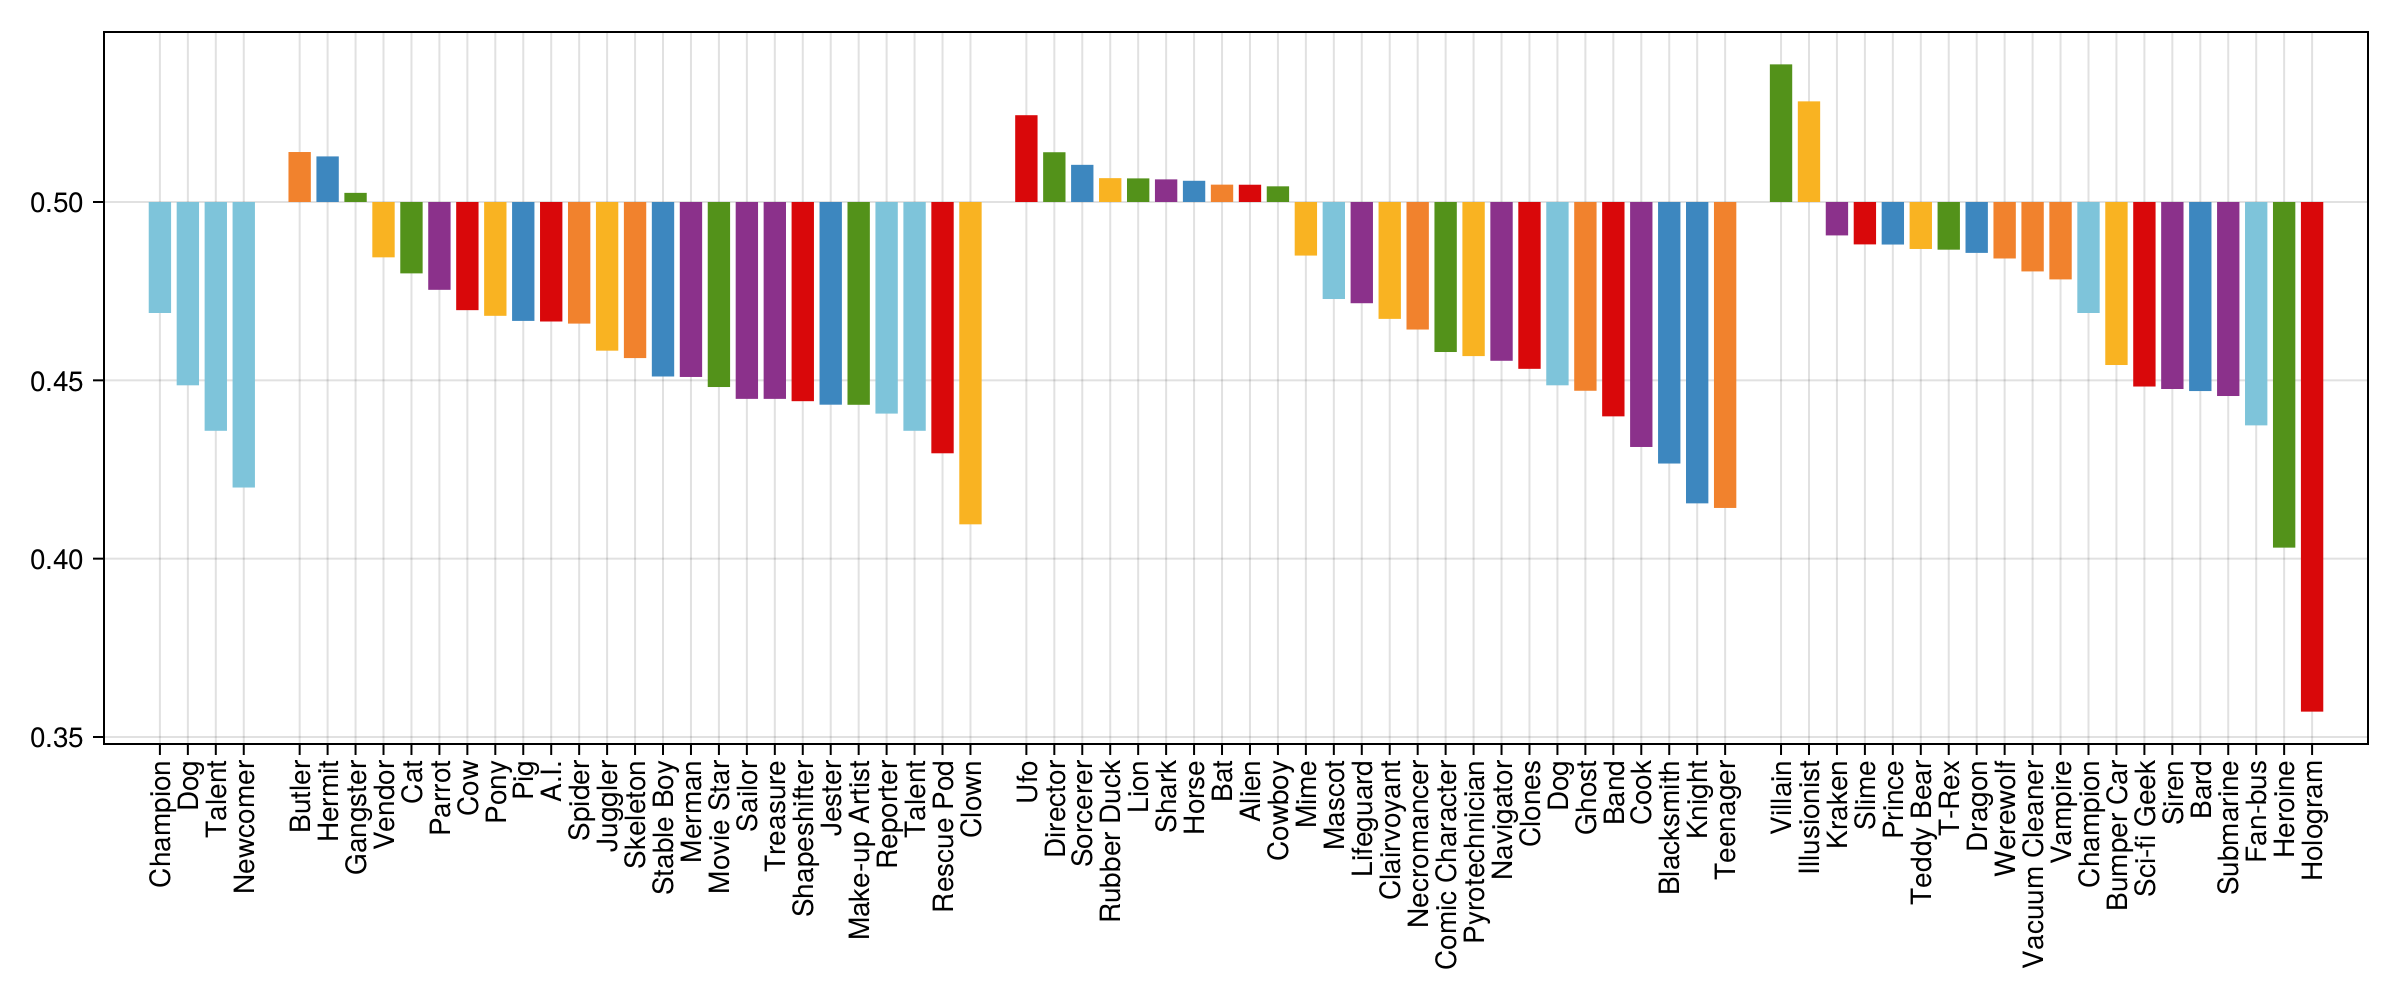

In [124]:
perm = sortperm(scards, by = tier)

fig = Figure(size = (1200,500))

ax = Axis(fig[1,1], 
    xticks = ((1:length(scards)) .+ Int.(tier.(scards)[perm]), name.(scards)[perm]), xticklabelrotation = pi/2, 
)
xlims!(ax, -1, length(scards) + 5)
# ylims!(ax, low = 0)

offset = 0
for t in instances(Tier)[1:4]
    sel = tier.(scards) .== t
    ys = freq[sel]
    xs = offset .+ (1:length(ys))
    offset = maximum(xs) + 1
    barplot!(ax, xs, ys, linewidth = 3, color = setcolor.(scards[sel]), fillto = 0.5)
end
fig

In [93]:
scards = copy(cards)
npicked = zeros(Int, length(scards))
ndrawn = zeros(Int, length(scards))
for (picks, draw) in zip(bestpicks, draws)
    for (i, d) in zip(picks, draw)
        ind = findfirst(isequal(d[i]), scards)
        !isnothing(ind) && (npicked[ind] += 1)
        for c in d
            ind = findfirst(isequal(c), scards)
            !isnothing(ind) && (ndrawn[ind] += 1)
        end
    end
end
perm = sortperm(npicked ./ ndrawn, rev = true); npicked = npicked[perm]; ndrawn = ndrawn[perm]; scards = scards[perm];
freq = npicked ./ ndrawn;

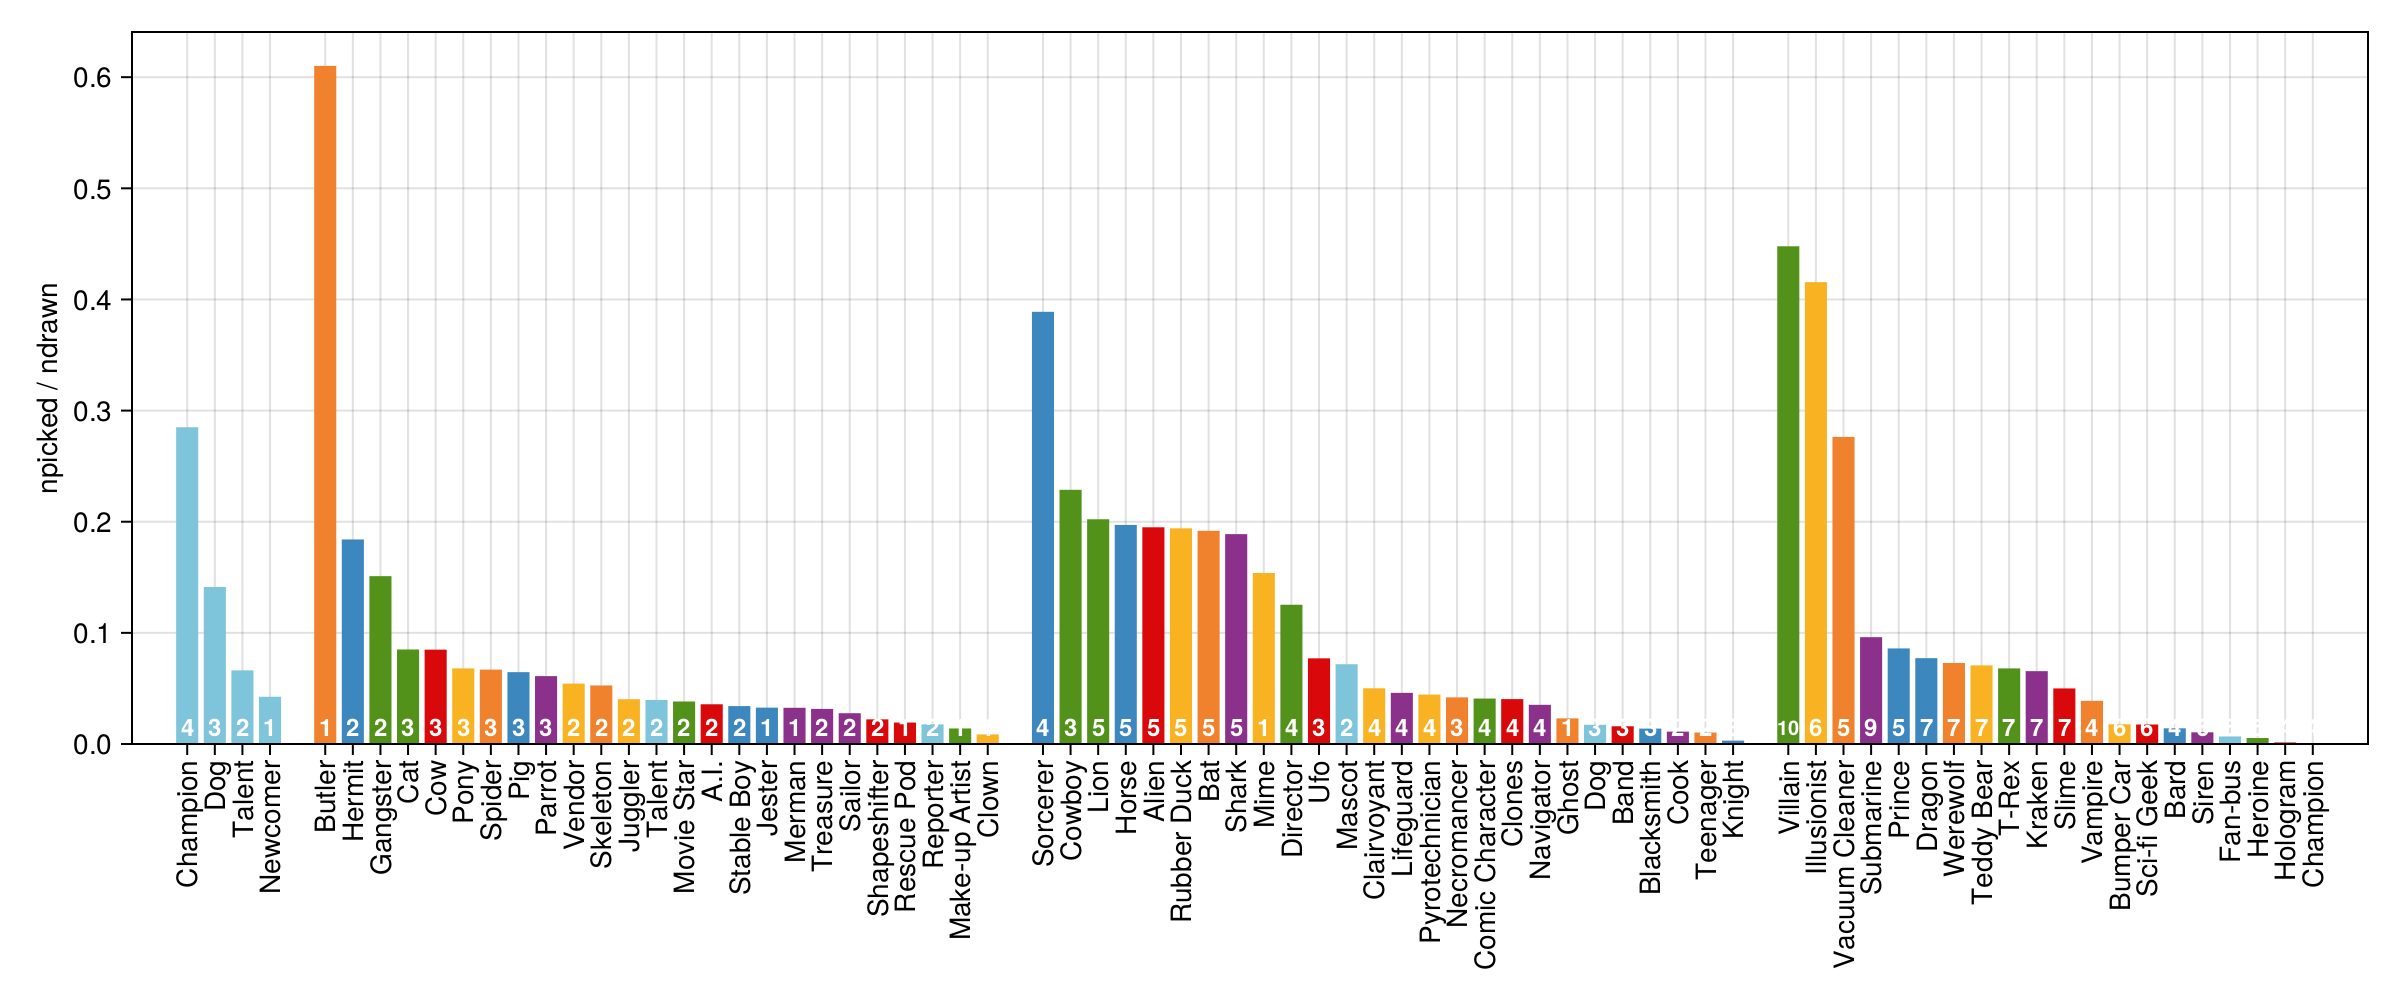

In [94]:
perm = sortperm(scards, by = tier)

fig = Figure(size = (1200,500))

ax = Axis(fig[1,1], ylabel = "npicked / ndrawn",
    xticks = ((1:length(scards)) .+ Int.(tier.(scards)[perm]), name.(scards)[perm]), xticklabelrotation = pi/2, 
)
xlims!(ax, -1, length(scards) + 5)
ylims!(ax, low = 0)

offset = 0
for t in instances(Tier)[1:4]
    sel = tier.(scards) .== t
    ys = freq[sel]
    xs = offset .+ (1:length(ys))
    offset = maximum(xs) + 1
    barplot!(ax, xs, ys, linewidth = 3, color = setcolor.(scards[sel]))
    # errorbars!(ax, xs, ys, sqrt.(ys ./ ndrawn[sel]), linewidth = 1, color = :black, whiskerwidth = 5)
    ts = string.(power.(scards[sel]))
    text!(ax, xs, 0ys .+ 0.015, text = ts, color = :white, fontsize = ifelse.(length.(ts) .== 1, 12, 10), align = (:center, :center), font = :bold)
end
fig

In [121]:
save("out/pickrates5.pdf", fig)

CairoMakie.Screen{PDF}


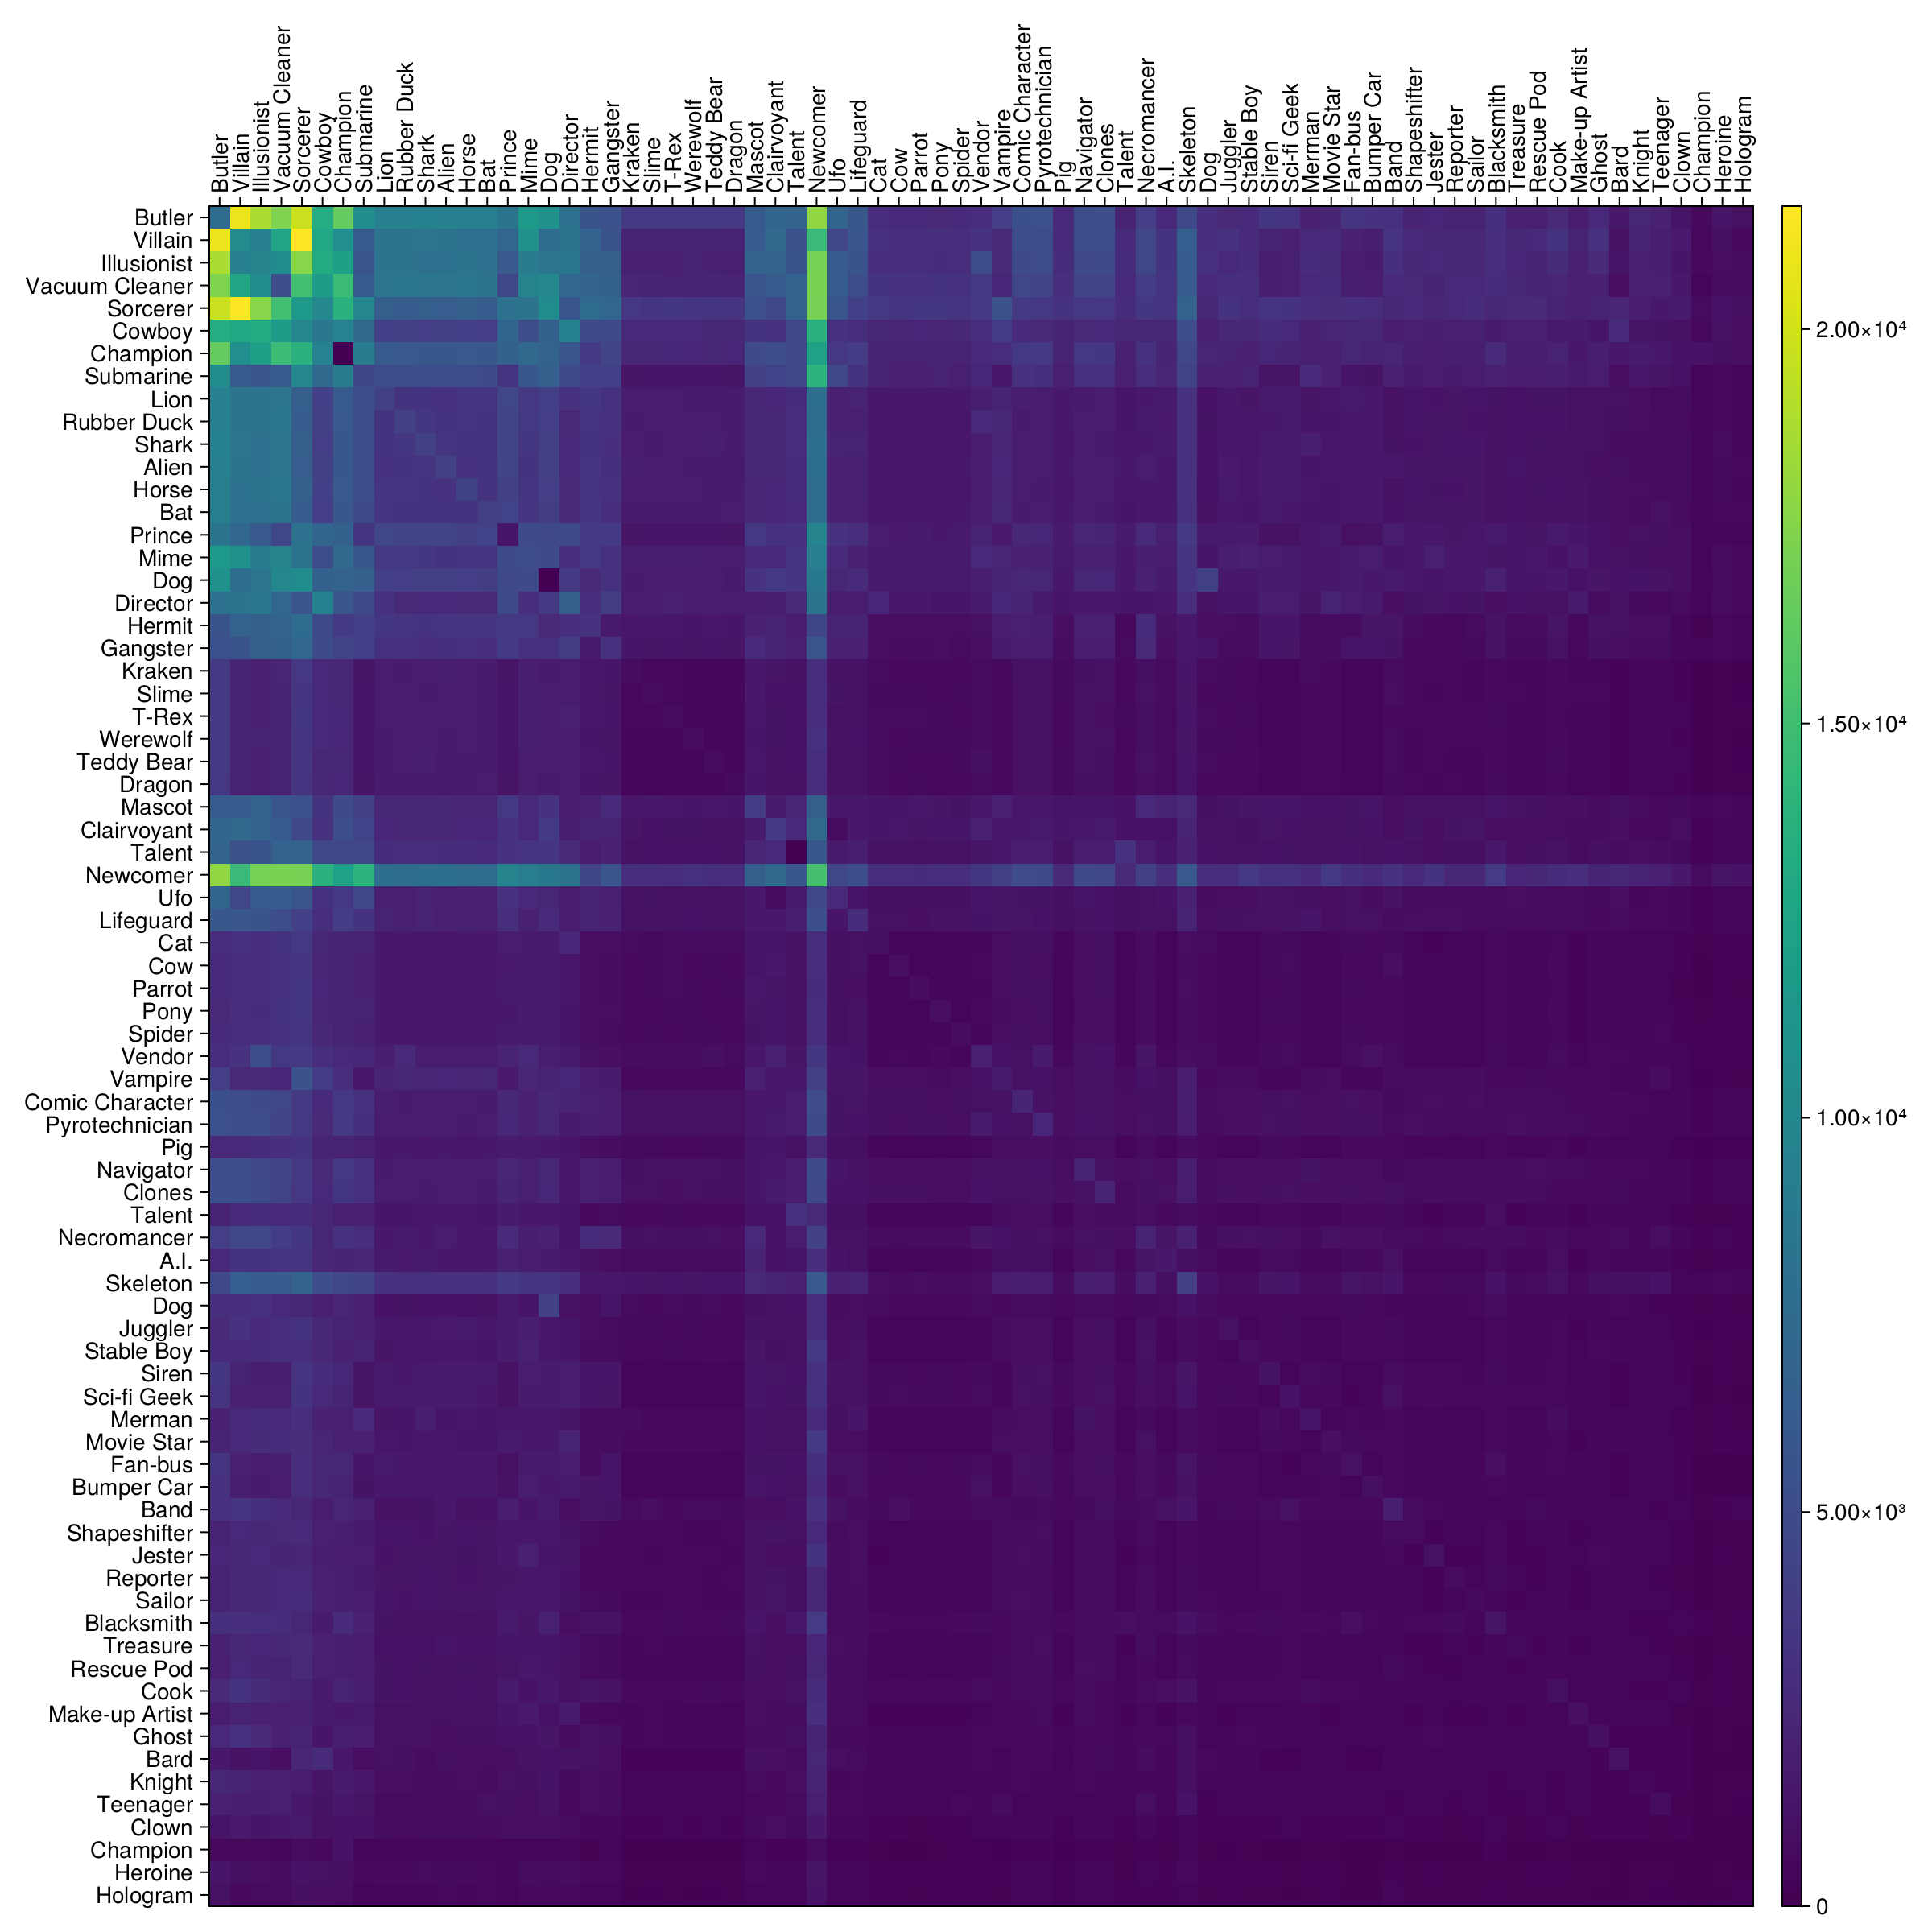

In [44]:
corr = zeros(Int, length(scards), length(scards))
for deck in bestdecks
    for i in eachindex(deck), j in 1:i-1
        id = findfirst(isequal(deck[i]), scards)
        jd = findfirst(isequal(deck[j]), scards)
        corr[id, jd] += 1
        id != jd && (corr[jd, id] += 1)
    end
end

fig = Figure(size = (1200,1200))
ax = Axis(fig[1,1], 
    xticks = (1:length(scards), name.(scards)), xticklabelrotation = pi/2, 
    yticks = (1:length(scards), name.(scards)), xaxisposition=:top, yreversed = true
)
plt = heatmap!(ax, corr)
Colorbar(fig[1,2], plt)
fig

In [167]:
ucards = sort(cards, by = tier)
# ucards = copy(cards)

i = 2
while i <= length(ucards)
    a = ucards[i].set != ucards[i-1].set
    b = ucards[i].tier != ucards[i-1].tier
    a && insert!(ucards, i, Card())
    b && insert!(ucards, i, Card())
    i += a + b + 1
end
pushfirst!(ucards, Card())

npicked = zeros(Int, length(ucards))
ndrawn = zeros(Int, length(ucards))
for (picks, draw) in zip(bestpicks, draws)
    for (i, d) in zip(picks, draw)
        ind = findfirst(isequal(d[i]), ucards)
        !isnothing(ind) && (npicked[ind] += 1)
        for c in d
            ind = findfirst(isequal(c), ucards)
            !isnothing(ind) && (ndrawn[ind] += 1)
        end
    end
end
freq = npicked ./ ndrawn;

npicked2 = zeros(Int, length(ucards), length(ucards))
ndrawn2 = zeros(Int, length(ucards), length(ucards))
@showprogress for (picks, draw) in zip(bestpicks, draws)
    for (ni, (i, di)) in enumerate(zip(picks, draw))
        isempty(di[i].name) && continue
        indi = findfirst(isequal(di[i]), ucards)
        for (nj, (j, dj)) in enumerate(zip(picks, draw))
            ni == nj && continue
            if !isempty(dj[j].name)
                npicked2[indi, findfirst(isequal(dj[j]), ucards)] += 1
            end
            for c in dj
                if !isempty(c.name)
                    ndrawn2[indi, findfirst(isequal(c), ucards)] += 1
                end
            end
        end
    end
end
corr = npicked2 ./ ndrawn2;

LoadError: ArgumentError: invalid index: nothing of type Nothing

In [158]:
ucards = sort(cards, by = tier)
# ucards = copy(cards)

i = 2
while i <= length(ucards)
    a = ucards[i].set != ucards[i-1].set
    b = ucards[i].tier != ucards[i-1].tier
    a && insert!(ucards, i, Card())
    b && insert!(ucards, i, Card())
    i += a + b + 1
end
pushfirst!(ucards, Card())

freq = [mean(rates[any.(isequal(c.name) ∘ name, bestdecks)]) for c in ucards];
corr = @showprogress [mean(rates[any.(isequal(c1.name) ∘ name, bestdecks) .&& any.(isequal(c2.name) ∘ name, bestdecks)]) for c1 in ucards, c2 in ucards];

In [166]:
fig = Figure(size = (1280,1200), fontsize = 11)
ax = Axis(fig[1,1], aspect = 1,
    xticks = (1:length(ucards), name.(ucards)), xticklabelrotation = pi/2, xticksvisible = false, xgridvisible = false,
    yticks = (1:length(ucards), name.(ucards)), xaxisposition=:top, yreversed = true, yticksvisible = false, ygridvisible = false
)
hidespines!(ax)
xlims!(ax, -0.5, length(ucards) + 0.5)
ylims!(ax, length(ucards) + 0.5, -0.5)


# ys = (npicked2 ./ ndrawn2 .- (npicked ./ ndrawn)') ./ max.(0.1, (npicked2 ./ ndrawn2))
ys = log10.((npicked2 ./ ndrawn2) ./ (npicked ./ ndrawn)')
# ys .= Makie.pseudolog10.(3 .* ys)
# for i in 1:size(ys, 1) ys[i,i] /= 3 end

plt = heatmap!(ax, ys, colorrange = (-1, 1), colormap = reverse(RGB.(cgrad(:bwr).colors)) .* 0.95, nan_color = :transparent)

hlines!(ax, 0.5:length(ucards)+0.5, color = :lightgrey, alpha = 0.2, linewidth = 1)
vlines!(ax, 0.5:length(ucards)+0.5, color = :lightgrey, alpha = 0.2, linewidth = 1)
image!(ax, -0.5..0.5, 0.5..length(ucards) + 0.5, reshape(parse.(RGB, setcolor.(ucards)), 1, :), interpolate = false)
image!(ax, 0.5..length(ucards) + 0.5, -0.5..0.5, reshape(parse.(RGB, setcolor.(ucards)), :, 1), interpolate = false)

ts = string.(power.(ucards))
text!(ax, 1:length(ucards), zeros(length(ucards)), text = ts, color = :white, fontsize = ifelse.(length.(ts) .== 1, 11, 9), align = (:center, :center), font = :bold)
text!(ax, zeros(length(ucards)), 1:length(ucards), text = ts, color = :white, fontsize = ifelse.(length.(ts) .== 1, 11, 9), align = (:center, :center), font = :bold)

Colorbar(fig[1,2], plt, ticklabelsize = 15, ticks = ([-1,0,1], ["0.1", "1", "10"]), minorticksvisible = true, minorticks = [log10.(0.1:0.1:0.9); log10.(1:1:10)])

fig

LoadError: UndefVarError: `npicked2` not defined

In [108]:
# save("out/synergies_bytier2.pdf", fig)

CairoMakie.Screen{PDF}


In [ ]:
ucards = copy(cards)

i = 2
while i <= length(ucards)
    a = ucards[i].set != ucards[i-1].set
    b = ucards[i].tier != ucards[i-1].tier
    a && insert!(ucards, i, Card())
    b && insert!(ucards, i, Card())
    i += a + b + 1
end
pushfirst!(ucards, Card())

corr = zeros(Int, length(ucards), length(ucards))
for deck in bestdecks
    for i in eachindex(deck), j in 1:i-1
        id = findfirst(isequal(deck[i]), ucards)
        jd = findfirst(isequal(deck[j]), ucards)
        corr[id, jd] += 1
        id != jd && (corr[jd, id] += 1)
    end
end

fig = Figure(size = (1200,1200), fontsize = 11)
ax = Axis(fig[1,1], 
    xticks = (1:length(ucards), name.(ucards)), xticklabelrotation = pi/2, xticksvisible = false, xgridvisible = false,
    yticks = (1:length(ucards), name.(ucards)), xaxisposition=:top, yreversed = true, yticksvisible = false, ygridvisible = false
)
hidespines!(ax)
xlims!(ax, -0.5, length(ucards) + 0.5)
ylims!(ax, length(ucards) + 0.5, -0.5)


ys = corr ./ max.(1, sum(corr, dims = 1))
for i in 1:length(ucards)
    for t in instances(Tier)
        ys[i, tier.(ucards) .== t] .-= mean(ys[i, tier.(ucards) .== t])
    end
end
# ys .-= mean(ys, dims = 2)
ys ./= max.(1e-10, maximum(abs, ys, dims = 2))
ys[isempty.(name.(ucards)), :] .= NaN
ys[:, isempty.(name.(ucards))] .= NaN


plt = heatmap!(ax, ys, colorange = (-1, 1), colormap = Reverse(:bwr), nan_color = :transparent)

hlines!(ax, 0.5:length(ucards)+0.5, color = :lightgrey, alpha = 0.2, linewidth = 1)
vlines!(ax, 0.5:length(ucards)+0.5, color = :lightgrey, alpha = 0.2, linewidth = 1)
image!(ax, -0.5..0.5, 0.5..length(ucards) + 0.5, reshape(parse.(RGB, setcolor.(ucards)), 1, :), interpolate = false)
image!(ax, 0.5..length(ucards) + 0.5, -0.5..0.5, reshape(parse.(RGB, setcolor.(ucards)), :, 1), interpolate = false)

ts = string.(power.(ucards))
text!(ax, 1:length(ucards), zeros(length(ucards)), text = ts, color = :white, fontsize = ifelse.(length.(ts) .== 1, 12, 10), align = (:center, :center), font = :bold)
text!(ax, zeros(length(ucards)), 1:length(ucards), text = ts, color = :white, fontsize = ifelse.(length.(ts) .== 1, 12, 10), align = (:center, :center), font = :bold)

# Colorbar(fig[1,2], plt, ticklabelsize = 15)

fig

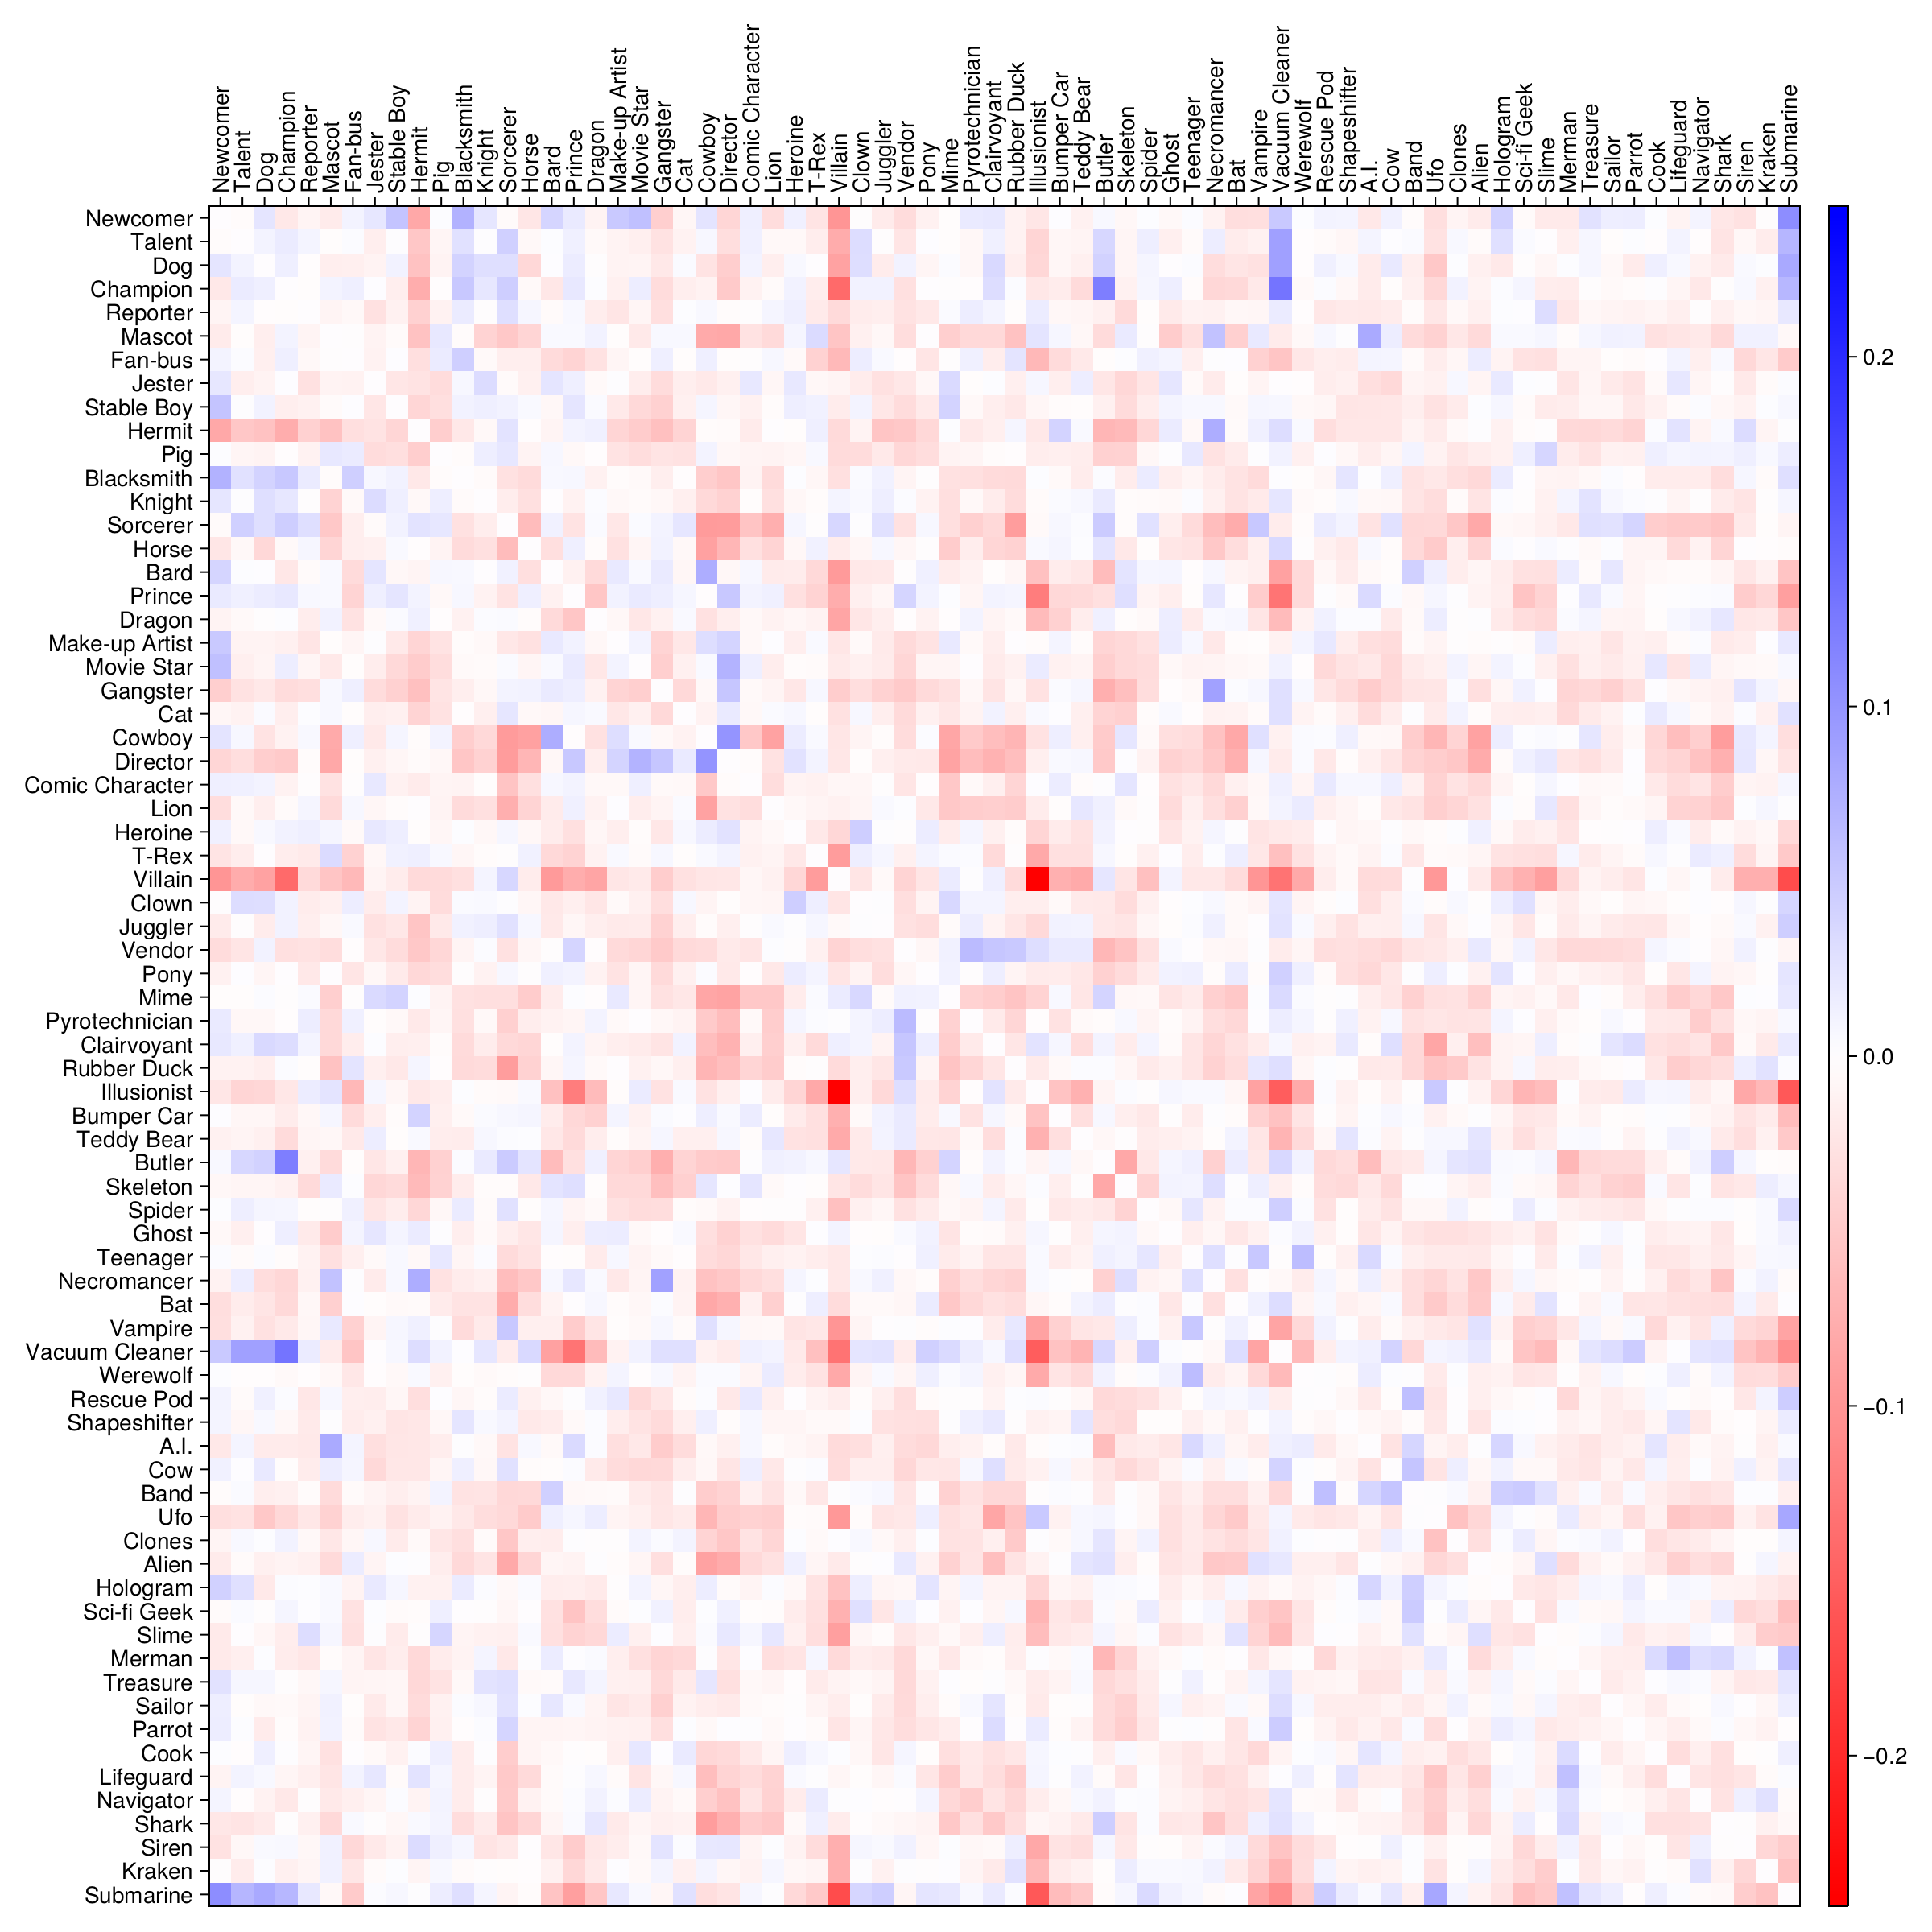

In [100]:
ucards = unique(name, cards)
events = [[sum(c .== deck) for deck in bestdecks] for c in ucards]
vals = zeros(length(events), length(events))
for i in eachindex(ucards), j in eachindex(ucards)
    ei = events[i]; ej = events[j]
    if ucards[i].set == ucards[j].set
        ei = 3/2*ei
    end
    vals[i,j] = cov(ei, ej) / std(ei) / std(ej)
end

# vals = cov.(events, reshape(events, 1, :)) ./ std.(events) ./ std.(events)'
vals -= I;
# vals .*= freq .* freq'

fig = Figure(size = (1200,1200))
ax = Axis(fig[1,1], 
    xticks = (1:length(ucards), name.(ucards)), xticklabelrotation = pi/2, 
    yticks = (1:length(ucards), name.(ucards)), xaxisposition=:top, yreversed = true
)
plt = heatmap!(ax, vals, colorrange = (-1, 1) .* norm(vals, Inf), colormap = Reverse(:bwr))
Colorbar(fig[1,2], plt)
fig

In [34]:
scards = copy(cards)
freq = zeros(length(scards))
for deck in bestdecks
    for c in deck
        freq[findfirst(isequal(c), scards)] += 1
    end
end
perm = sortperm(freq, rev = true); freq = freq[perm]; scards = scards[perm];
freq ./= niterations * nplayers;

In [19]:
prog = Progress(1000)
for _ in 1:prog.n
    for i in 1:nplayers
        newpicks = ifelse.(rand.() .< 0.3, rand.(eachindex.(playerdraws[i])), playerpicks[i])
        newdeck = filter(!isempty ∘ name, getindex.(playerdraws[i], newpicks))
        
        rold = winrate(nsamples = 100) do k
            State(playerdecks[i], playerdecks[mod1(k, nplayers)], shuffle = true)
        end
        rnew = winrate(nsamples = 100) do k
           State(newdeck, playerdecks[mod1(k, nplayers)], shuffle = true)
        end
        if rnew > rold
            playerpicks[i] = newpicks
            playerdecks[i] = newdeck
            winrates[i] = rnew
        end
    end
    perm = sortperm(winrates, rev = true); winrates = winrates[perm]; playerdraws = playerdraws[perm]; playerpicks = playerpicks[perm]; playerdecks = playerdecks[perm]
    sorteddecks = sort.(playerdecks, by = c -> (c.tier, c.name))
    next!(prog, showvalues = [(round(w, digits = 2), "$(length(unique(name.(deck)))) types. " * join(name.(deck), ", ")) for (w, deck) in zip(winrates, sorteddecks)])
end
# for deck in decks println(name.(deck)) end

Progress: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| Time: 0:00:10
  0.73:  6 types. Talent, Mascot, Mascot, Necromancer, Sorcerer, Illusionist, Villain, Villain
  0.62:  10 types. Champion, Butler, Butler, Vendor, Blacksmith, Cowboy, Shark, Sorcerer, Sorcerer, Illusionist, Slime, Villain
  0.6:   10 types. Dog, Talent, Butler, Hermit, Director, Lion, Sorcerer, Sorcerer, Ufo, Vacuum Cleaner, Vacuum Cleaner, Villain
  0.52:  9 types. Butler, Butler, Cat, Pyrotechnician, Pyrotechnician, Shark, Sorcerer, Ufo, T-Rex, Vacuum Cleaner, Werewolf
  0.48:  10 types. Newcomer, Butler, Butler, Sailor, Cowboy, Cowboy, Horse, Sorcerer, Ufo, Bard, Vampire, Villain
  0.48:  8 types. Dog, Talent, Butler, Talent, Talent, Cowboy, Dog, Necromancer, Rubber Duck, Rubber Duck, Prince, Sci-fi Geek, Sci-fi Geek
  0.42:  12 types. Champion, Butler, Parrot, Shapeshifter, Treasure, Alien, Bat, Bat, Navigator, Necromancer, Illusi

In [19]:
nplayers = 20
playerpiles = [deepcopy(piles) for i in 1:nplayers]
playerslots = [Card[] for i in 1:nplayers]
winrates = fill(0.5, nplayers);

for i in 1:nplayers
    for j in eachindex(slots)
        push!(playerslots[i], popat!(playerpiles[i][slots[j]], rand(eachindex(playerpiles[i][slots[j]]))))
    end
end

In [56]:
prog = Progress(1000)
for _ in 1:prog.n
    for i in 3:3
        newslots = deepcopy(playerslots[i])
        newpiles = deepcopy(playerpiles[i])
        
        for _ in 1:rand(1:1)
            piv = rand(eachindex(slots))
            s = newslots[piv].origin
            ind = rand(eachindex(newpiles[s]))
            newslots[piv], newpiles[s][ind] = newpiles[s][ind], newslots[piv]
        end

        deck = filter(!isempty ∘ name, playerslots[i])
        newdeck = filter(!isempty ∘ name, newslots)
        
        rold = winrate(nsamples = 10000) do 
            deck2 = filter(!isempty ∘ name, rand(playerslots))
            State(shuffle(deck), shuffle(deck2))
        end
        rnew = winrate(nsamples = 10000) do 
            deck2 = filter(!isempty ∘ name, rand(playerslots))
            State(shuffle(newdeck), shuffle(deck2))
        end
        if rnew > rold
            playerslots[i] = newslots
            playerpiles[i] = newpiles
            winrates[i] = rnew
        end
    end
    # perm = sortperm(winrates, rev = true); playerslots = playerslots[perm]; playerpiles = playerpiles[perm]; winrates = winrates[perm]
    decks = [sort(filter(!isempty ∘ name, s), by = c -> (Dict("A"=>1,"B"=>2,"C"=>3,"S"=>0)[c.origin], c.name)) for s in playerslots]
    next!(prog, showvalues = [(round(w, digits = 2), "$(length(unique(name.(deck)))) types. " * join(name.(deck), ", ")) for (w, deck) in zip(winrates, decks)])
end
# for deck in decks println(name.(deck)) end

Progress:  66%|█████████████████████████████████████████████████████████████████████████████████                                         |  ETA: 0:03:44
  0.94:  6 types. Champion, Newcomer, Newcomer, Newcomer, Vendor, Vendor, Vendor, Vendor, Clairvoyant, Clairvoyant, Clairvoyant, Rubber Duck, Rubber Duck, Illusionist, Illusionist, Illusionist
  0.72:  7 types. Champion, Dog, Vendor, Vendor, Vendor, Cowboy, Cowboy, Cowboy, Director, Director, Illusionist, Illusionist, Prince
  0.74:  5 types. Champion, Rescue Pod, Rescue Pod, Cowboy, Cowboy, Cowboy, Cowboy, Director, Villain, Villain, Villain
  0.68:  4 types. Newcomer, Newcomer, Cowboy, Director, Director, Director, Director, Villain, Villain, Villain
  0.68:  6 types. Champion, Gangster, Gangster, Cowboy, Cowboy, Cowboy, Director, Director, T-Rex, Vampire, Vampire
  0.62:  6 types. Champion, Gangster, Gangster, Gangster, Mascot, Mascot, Mascot, Necromancer, Necromancer, Dragon, Illusionist, Illusionist
  0.61:  5 types. Newcomer, New

LoadError: InterruptException:

In [53]:
winrate(State(deepcopy(playerslots[1]), deepcopy(playerslots[2])), nsamples = 10000, showprogress = true)

Progress: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| Time: 0:00:05


0.5303

In [24]:
argmax(winrates)

1

In [12]:
piles = Dict(
    "A" => makepile(Acards),
    "B" => makepile(Bcards),
    "C" => makepile(Ccards),
    "S" => repeat([C.newcomer, C.newcomer, C.newcomer, C.talent, C.dog, C.champion], 8)
)
for (key, pile) in piles
    append!(pile, fill(Card(name = "", origin = key), length(pile)))
end
slots = [fill("S", 6); fill("A", 4); fill("B", 5); fill("C", 3)];

In [13]:
nplayers = 8
playerslots = [Card[] for i in 1:nplayers]
winrates = fill(0.5, nplayers);

for i in 1:nplayers
    for j in eachindex(slots)
        push!(playerslots[i], popat!(piles[slots[j]], rand(eachindex(piles[slots[j]]))))
    end
end

In [14]:
prog = Progress(1000)
for _ in 1:prog.n
    for i in 1:nplayers
        newslots = deepcopy(playerslots[i])
        newpiles = deepcopy(piles)
        
        for _ in 1:rand(1:3)
            piv = rand(eachindex(slots))
            s = newslots[piv].origin
            ind = rand(eachindex(newpiles[s]))
            newslots[piv], newpiles[s][ind] = newpiles[s][ind], newslots[piv]
        end
        if sum(newslots .== C.newcomer) > 3 || sum(newslots .== C.talent) > 1 || sum(newslots .== C.dog) > 1 || sum(newslots .== C.champion) > 1
            continue
        end

        deck = filter(!isempty ∘ name, playerslots[i])
        newdeck = filter(!isempty ∘ name, newslots)
        
        rold = winrate(nsamples = 200) do 
            deck2 = filter(!isempty ∘ name, rand(playerslots))
            State(shuffle(deck), shuffle(deck2))
        end
        rnew = winrate(nsamples = 200) do 
            deck2 = filter(!isempty ∘ name, rand(playerslots))
            State(shuffle(newdeck), shuffle(deck2))
        end
        if rnew > rold
            playerslots[i] = newslots
            piles = newpiles
            winrates[i] = rnew
        end
    end
    perm = sortperm(winrates, rev = true); playerslots = playerslots[perm]; winrates = winrates[perm]
    decks = [sort(filter(!isempty ∘ name, s), by = c -> (Dict("A"=>1,"B"=>2,"C"=>3,"S"=>0)[c.origin], c.name)) for s in playerslots]
    next!(prog, showvalues = [(round(w, digits = 2), "$(length(unique(name.(deck)))) types. " * join(name.(deck), ", ")) for (w, deck) in zip(winrates, decks)])
end
# for deck in decks println(name.(deck)) end

Progress: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| Time: 0:01:57
  0.86:  5 types. Rescue Pod, Director, Director, Director, Ufo, Illusionist, Villain, Villain
  0.82:  6 types. Newcomer, Newcomer, Newcomer, Cat, Make-up Artist, Cowboy, Cowboy, Cowboy, Ufo, Bard, Bard, Bard
  0.6:   6 types. Newcomer, Newcomer, Newcomer, Vendor, Lifeguard, Lifeguard, Pyrotechnician, Pyrotechnician, Pyrotechnician, Illusionist, Illusionist, T-Rex
  0.4:   10 types. Champion, Newcomer, Newcomer, Newcomer, Butler, Dog, Lion, Pyrotechnician, Sorcerer, Ufo, Vacuum Cleaner, Vacuum Cleaner, Villain
  0.4:   8 types. Talent, Cat, Rescue Pod, Talent, Alien, Alien, Mascot, Necromancer, Slime, Slime, T-Rex
  0.39:  8 types. Champion, Dog, Newcomer, Newcomer, Newcomer, Bat, Clairvoyant, Clairvoyant, Rubber Duck, Kraken, Submarine, Submarine
  0.36:  9 types. Talent, A.I., Butler, Clairvoyant, Cowboy, Horse, Mascot, Prince, Prin

In [38]:
slots = [
    [nothing, starter["newcomer"]],
    [nothing, starter["newcomer"]],
    [nothing, starter["newcomer"]],
    [nothing, starter["talent"]],
    [nothing, starter["dog"]],
    [nothing, starter["champion"]],
    [nothing, Acards...], [nothing, Acards...], [nothing, Acards...], [nothing, Acards...],
    [nothing, Bcards...], [nothing, Bcards...], [nothing, Bcards...], [nothing, Bcards...], [nothing, Bcards...],
    [nothing, Ccards...], [nothing, Ccards...], [nothing, Ccards...],
];
playerpicks = map(1:9) do _
    picks = rand.(eachindex.(slots))
    for piv in 1:length(picks)
        rand() < 0.5 && (picks[piv] = 1)
    end
    picks
end;
winrates = fill(0.5, length(playerpicks));

In [43]:
prog = Progress(1000)#, dt = 0.5)
for _ in 1:prog.n
    for i in 1:length(playerpicks)
        deck = convert.(Card, filter(!isnothing, getindex.(slots, playerpicks[i])));
        
        newpicks = copy(playerpicks[i]); 
        for _ in 1:3
            piv = rand(eachindex(playerpicks[i]))
            newpick = rand(1:length(slots[piv]))
            rand() < 0.2 && (newpick = 1)
            newpicks[piv] = newpick
        end
        newdeck = convert.(Card, filter(!isnothing, getindex.(slots, newpicks)));
        
        rold = winrate(nsamples = 200) do 
            deck2 = convert.(Card, filter(!isnothing, getindex.(slots, rand(playerpicks))))
            State(shuffle(deck), shuffle(deck2))
        end
        rnew = winrate(nsamples = 200) do 
            deck2 = convert.(Card, filter(!isnothing, getindex.(slots, rand(playerpicks))))
            State(shuffle(newdeck), shuffle(deck2))
        end
        if rnew > rold
            playerpicks[i] = newpicks
            winrates[i] = rnew
        end
    end
    perm = sortperm(winrates, rev = true); playerpicks = playerpicks[perm]; winrates = winrates[perm]
    decks = [convert.(Card, filter(!isnothing, getindex.(slots, picks))) for picks in playerpicks]
    next!(prog, showvalues = [(round(w, digits = 2), join(name.(deck), ", ")) for (w, deck) in zip(winrates, decks)])
end
# for deck in decks println(name.(deck)) end

Progress: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| Time: 0:01:53
  0.82:  Stable Boy, Stable Boy, Stable Boy, Stable Boy, Knight, Knight, Knight, Knight, Knight, Villain, Villain, Villain
  0.72:  Hermit, Hermit, Spider, Spider, Lion, Lion, Lion, Lion, Lion, Villain, Villain, Villain
  0.67:  Make-up Artist, Rescue Pod, Make-up Artist, Make-up Artist, Alien, Horse, Horse, Horse, Horse, Villain, Villain, Villain
  0.64:  Butler, Hermit, Hermit, Butler, Ufo, Knight, Ufo, Shark, Ufo, Hologram, Hologram, Hologram
  0.57:  Merman, Merman, Merman, Bat, Bat, Bat, Shark, Shark, Villain, Villain, Villain
  0.57:  Newcomer, Newcomer, Newcomer, Dog, Make-up Artist, Make-up Artist, Make-up Artist, Make-up Artist, Ghost, Rubber Duck, Rubber Duck, Dog, Rubber Duck, Kraken, Kraken, Kraken
  0.34:  Spider, Bat, Bat, Director, Director, Alien, Hologram, Illusionist, Villain
  0.22:  Hermit, Hermit, Butler, Gangster,

In [4]:
[1,2,3][Not(1)]

LoadError: UndefVarError: `Not` not defined

In [2]:
decks = []
@showprogress for _ in 1:100
    slots = [
        [nothing, starter["talent"]],
        [nothing, starter["dog"]],
        [nothing, starter["champion"]],
        [nothing, A...], [nothing, A...], [nothing, A...], [nothing, A...],
        [nothing, B...], [nothing, B...], [nothing, B...], [nothing, B...], [nothing, B...],
        [nothing, C...], [nothing, C...], [nothing, C...],
    ];
    picks = rand.(eachindex.(slots))
    for piv in 1:length(picks)
        rand() < 0.5 && (picks[piv] = 1)
    end
    # prog = Progress(1000)
    for i in 1:1000
        deck = convert.(Card, filter(!isnothing, getindex.(slots, picks)));
        piv = rand(eachindex(picks))
        newpick = rand(1:length(slots[piv]))
        rand() < 0.2 && (newpick = 1)
        newpicks = copy(picks); newpicks[piv] = newpick
        newdeck = convert.(Card, filter(!isnothing, getindex.(slots, newpicks)));
    
        nsamples = 100
        val = sum(1:nsamples) do _
            state = State(shuffle(newdeck), shuffle(deck))
            state.toplay = rand(Bool)
            simulate!(state) == 1
        end / nsamples
        if val > 0.5
            picks = newpicks
        end
        # next!(prog, showvalues = ((:deck, name.(deck)),))
    end
    push!(decks, convert.(Card, filter(!isnothing, getindex.(slots, picks))))
end

Progress: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| Time: 0:10:17


In [19]:
vals = fill(0.5, length(decks), length(decks))
prog = Progress(length(decks) * (length(decks) - 1) ÷ 2)
for i in 1:length(decks), j in 1:i-1
    nsamples = 1000
    vals[i,j] = sum(1:nsamples) do _
        state = State(shuffle(decks[i]), shuffle(decks[j]))
        state.toplay = rand(Bool)
        simulate!(state) == 1
    end / nsamples
    vals[j,i] = 1 - vals[i, j]
    next!(prog)
end

Progress: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| Time: 0:02:33


In [20]:
perm = sortperm(sum(vals, dims = 2)[:], rev = true);
for i in 1:10 
    print(name.(decks[perm[i]])); print(" "); println(mean(vals, dims = 2)[perm[i]]) 
end

["Dog", "Stable Boy", "Stable Boy", "Stable Boy", "Stable Boy", "Cowboy", "Cowboy", "Cowboy", "Cowboy", "Cowboy", "Villain", "Villain", "Villain"] 0.8231400000000003
["Dog", "Champion", "Vendor", "Vendor", "Vendor", "Vendor", "Ghost", "Rubber Duck", "Rubber Duck", "Rubber Duck", "Rubber Duck", "Illusionist", "Illusionist", "Illusionist"] 0.8183600000000001
["Dog", "A.I.", "A.I.", "A.I.", "A.I.", "Band", "Band", "Band", "Ufo", "Band", "Slime", "Slime", "Slime"] 0.8167399999999999
["Hermit", "Hermit", "Hermit", "Hermit", "Cowboy", "Director", "Cowboy", "Cowboy", "Director", "Villain", "Villain", "Villain"] 0.8021799999999999
["Gangster", "Gangster", "Gangster", "Gangster", "Director", "Director", "Cowboy", "Cowboy", "Cowboy", "Villain", "Villain", "Villain"] 0.8019300000000001
["Dog", "Champion", "Vendor", "Vendor", "Vendor", "Vendor", "Director", "Cowboy", "Cowboy", "Cowboy", "Cowboy", "Illusionist", "Illusionist", "Illusionist"] 0.79634
["Talent", "Champion", "Vendor", "Vendor", "Vendo

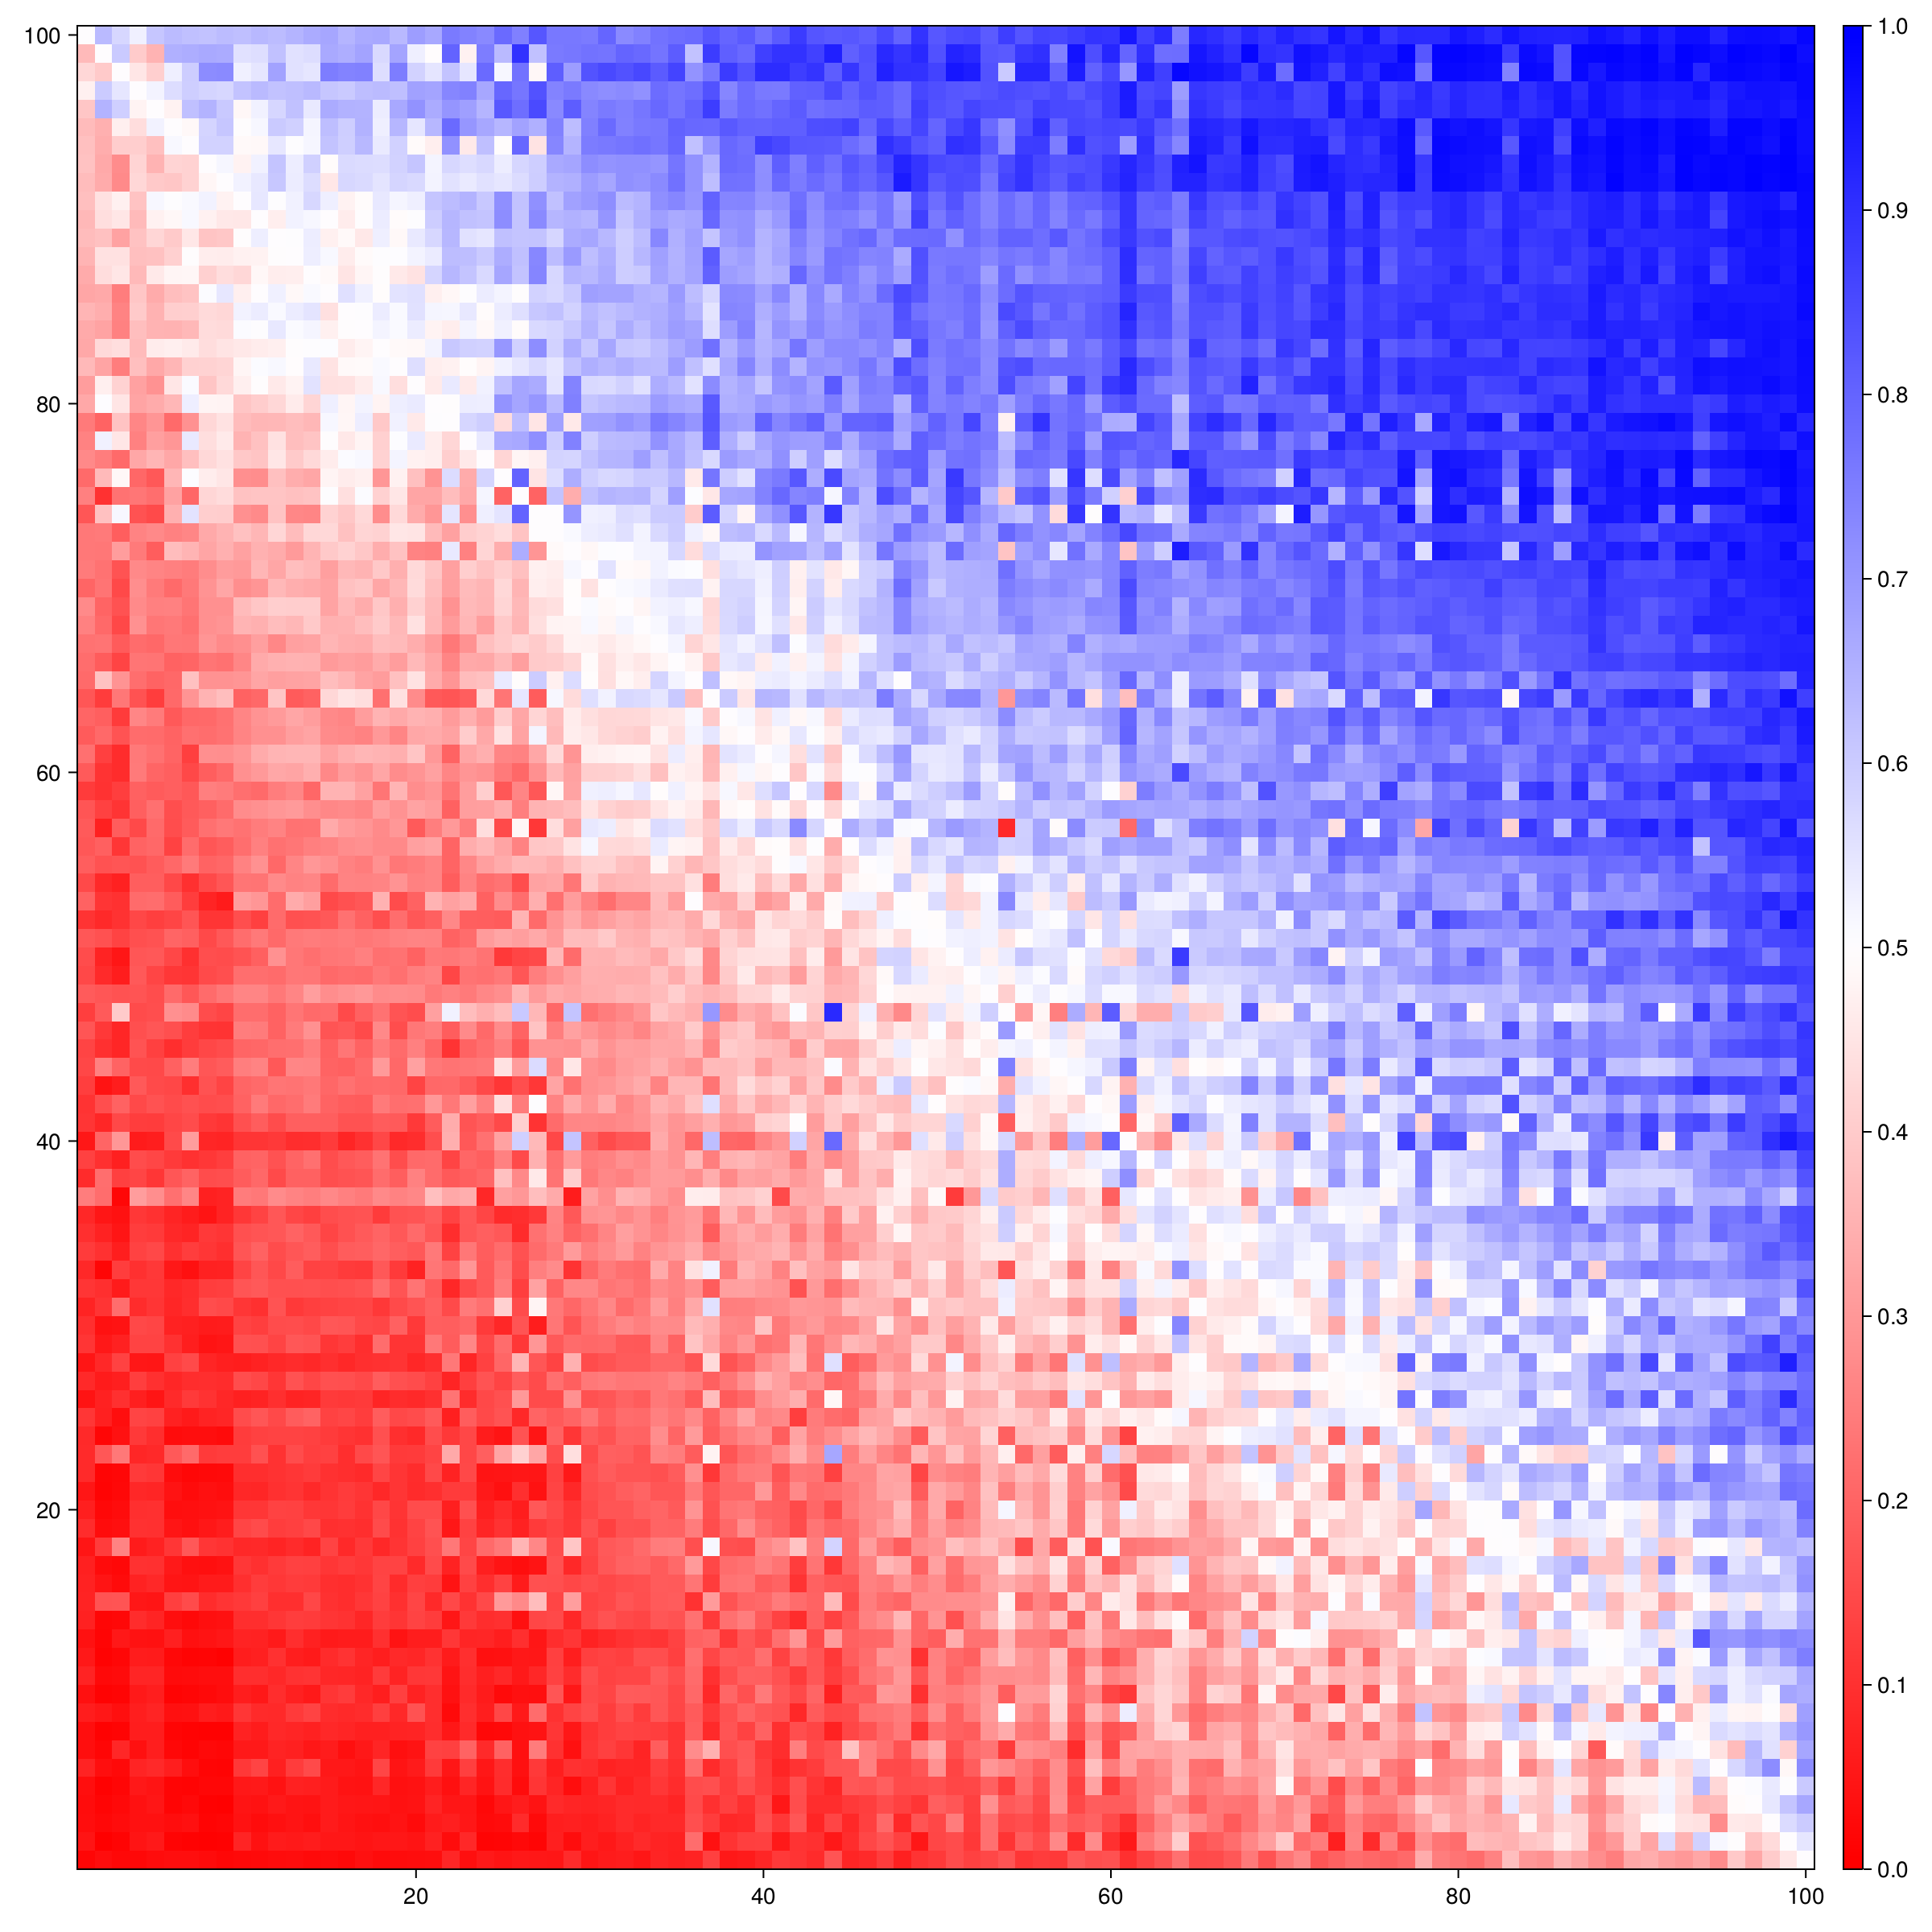

In [44]:
perm = sortperm(sum(vals, dims = 2)[:], rev = true);
fig = Figure(size = (1200,1200))
ax = Axis(fig[1,1])
c = ceil(norm(vals .- 0.5, Inf), digits = 1)
plt = heatmap!(ax, vals[reverse(perm), perm]', colorrange = (0.5 - c, 0.5 + c), colormap = Reverse(:bwr))
Colorbar(fig[1,2], plt, ticks = 0:0.1:1)
fig

In [43]:
deck = [starter["dog"], starter["champion"], funfair["vendor"], funfair["vendor"], funfair["vendor"], funfair["vendor"], funfair["rubberduck"], funfair["rubberduck"], funfair["pyrotechnician"], funfair["pyrotechnician"], funfair["pyrotechnician"], funfair["pyrotechnician"], funfair["illusionist"], funfair["illusionist"], funfair["illusionist"]]
deck2 = fill(starter["newcomer"], 85)
println(length(unique(deck)))
sum(1:1000) do _
    state = State(shuffle(decks[perm[3]]), shuffle(deck2))
    simulate!(state) == 1
end / 1000

6


0.202

In [170]:
decks = decks[perm[1:100]];

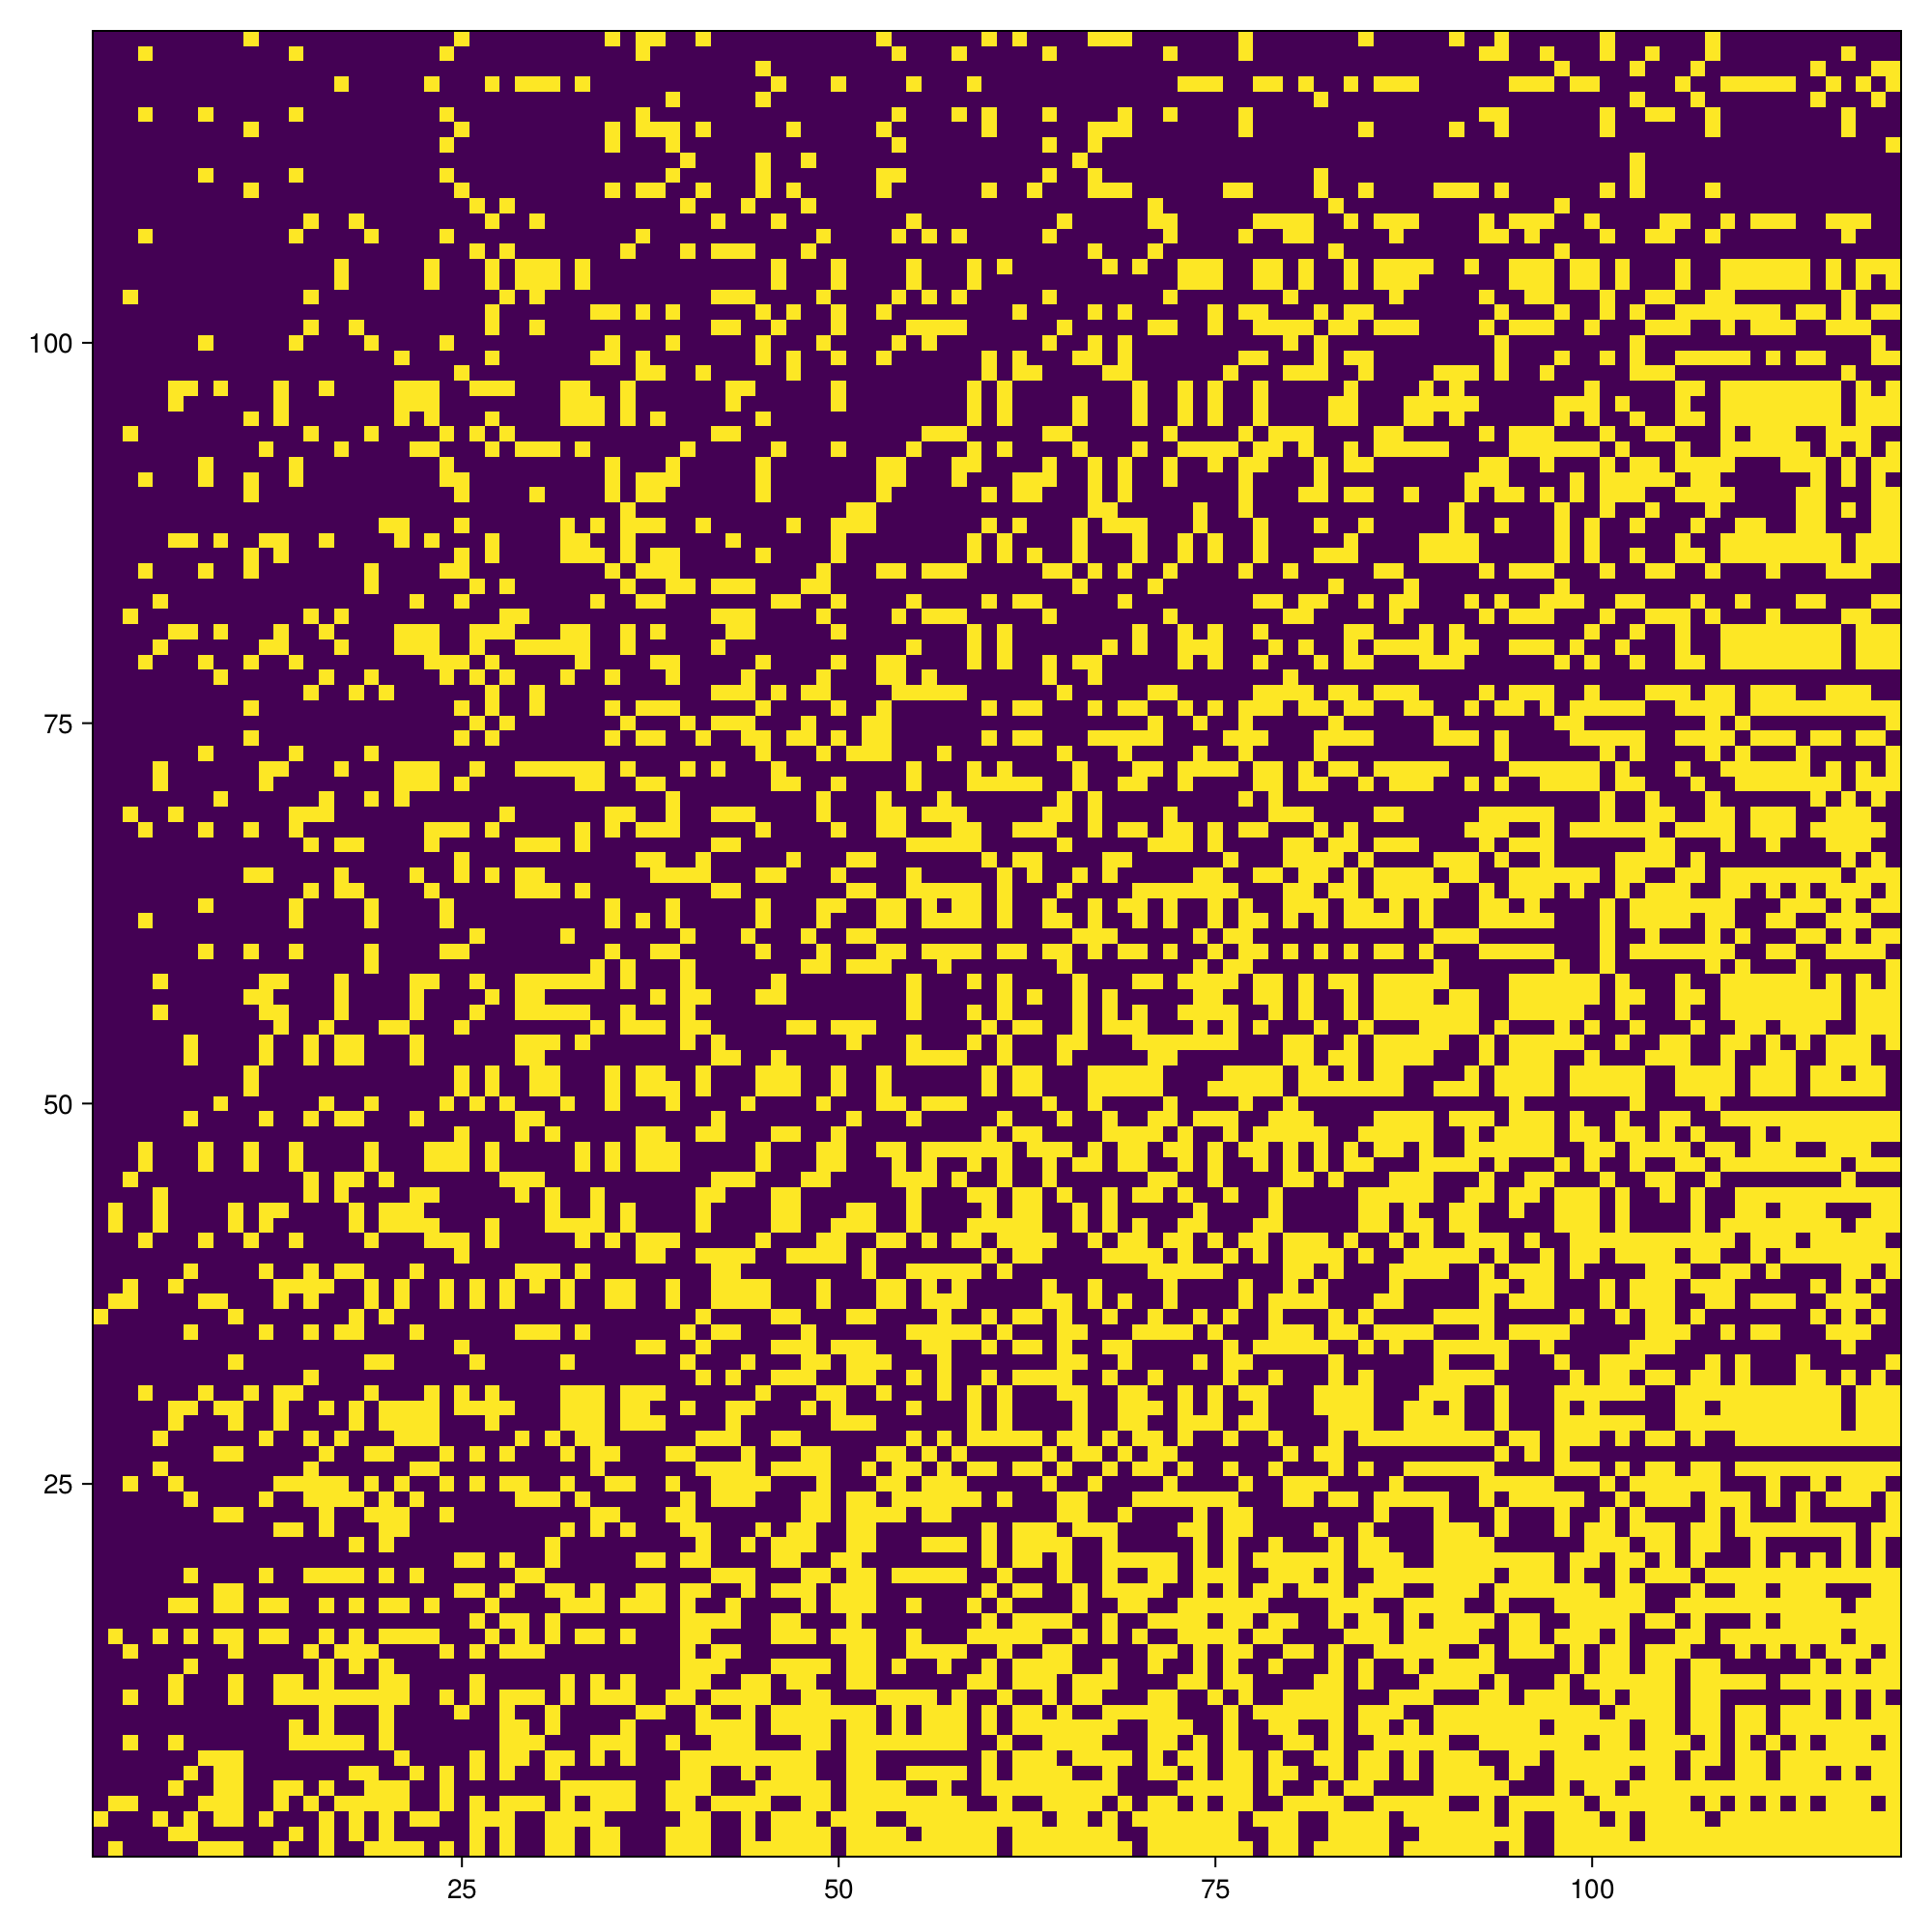

In [138]:
starterdeck = getindex.(Ref(starter), ["newcomer", "newcomer", "newcomer", "talent", "dog", "champion"]);
shuffles = unique([shuffle(starterdeck) for i in 1:1000]);
vals = [(simulate!(State(copy(s2), copy(s1))) == 1) for s1 in shuffles, s2 in shuffles]
perm = sortperm(sum(vals, dims = 2)[:])
heatmap(vals[perm, perm])

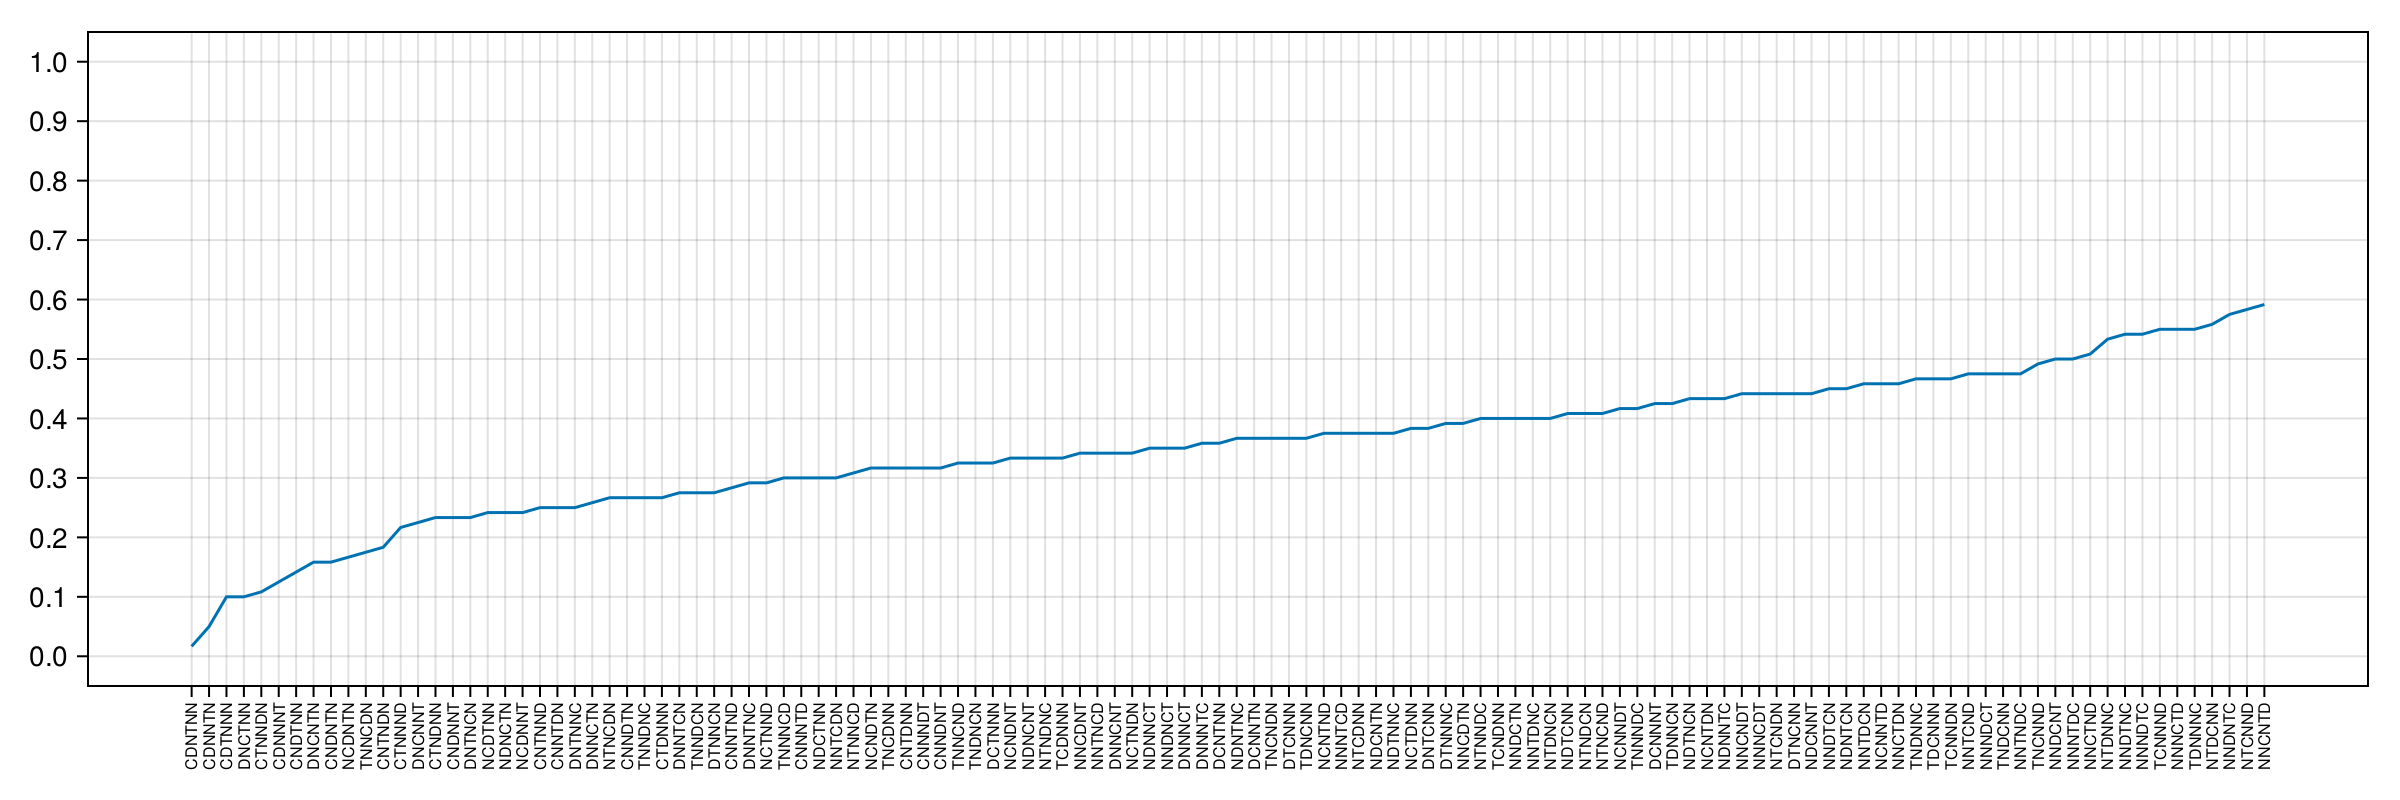

In [139]:
fig = Figure(size = (1200,400))
labels = [join(first.(name.(s))) for s in shuffles]
ax = Axis(fig[1,1], xticks = (1:length(perm), labels[perm]), xticklabelrotation = pi/2, xticklabelsize = 8, yticks = 0:0.1:1)
lines!(ax, mean(vals, dims = 2)[:][perm])
yinc!(ax, 0, 1)
fig

In [158]:
vals = fill(0.5, length(allcards), length(allcards))
prog = Progress(length(allcards) * (length(allcards) - 1) ÷ 2)
for i in 1:length(allcards), j in 1:i-1
    nsamples = 1000
    vals[i,j] = sum(1:nsamples) do _
        cs = rand(allcards, 10)
        deck1 = [cs..., allcards[i]]
        deck2 = [cs..., allcards[j]] 
        state = State(shuffle(deck1), shuffle(deck2))
        state.toplay = rand(Bool)
        simulate!(state) == 1
    end / nsamples
    vals[j,i] = 1 - vals[i, j]
    next!(prog)
end

Progress: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| Time: 0:01:21


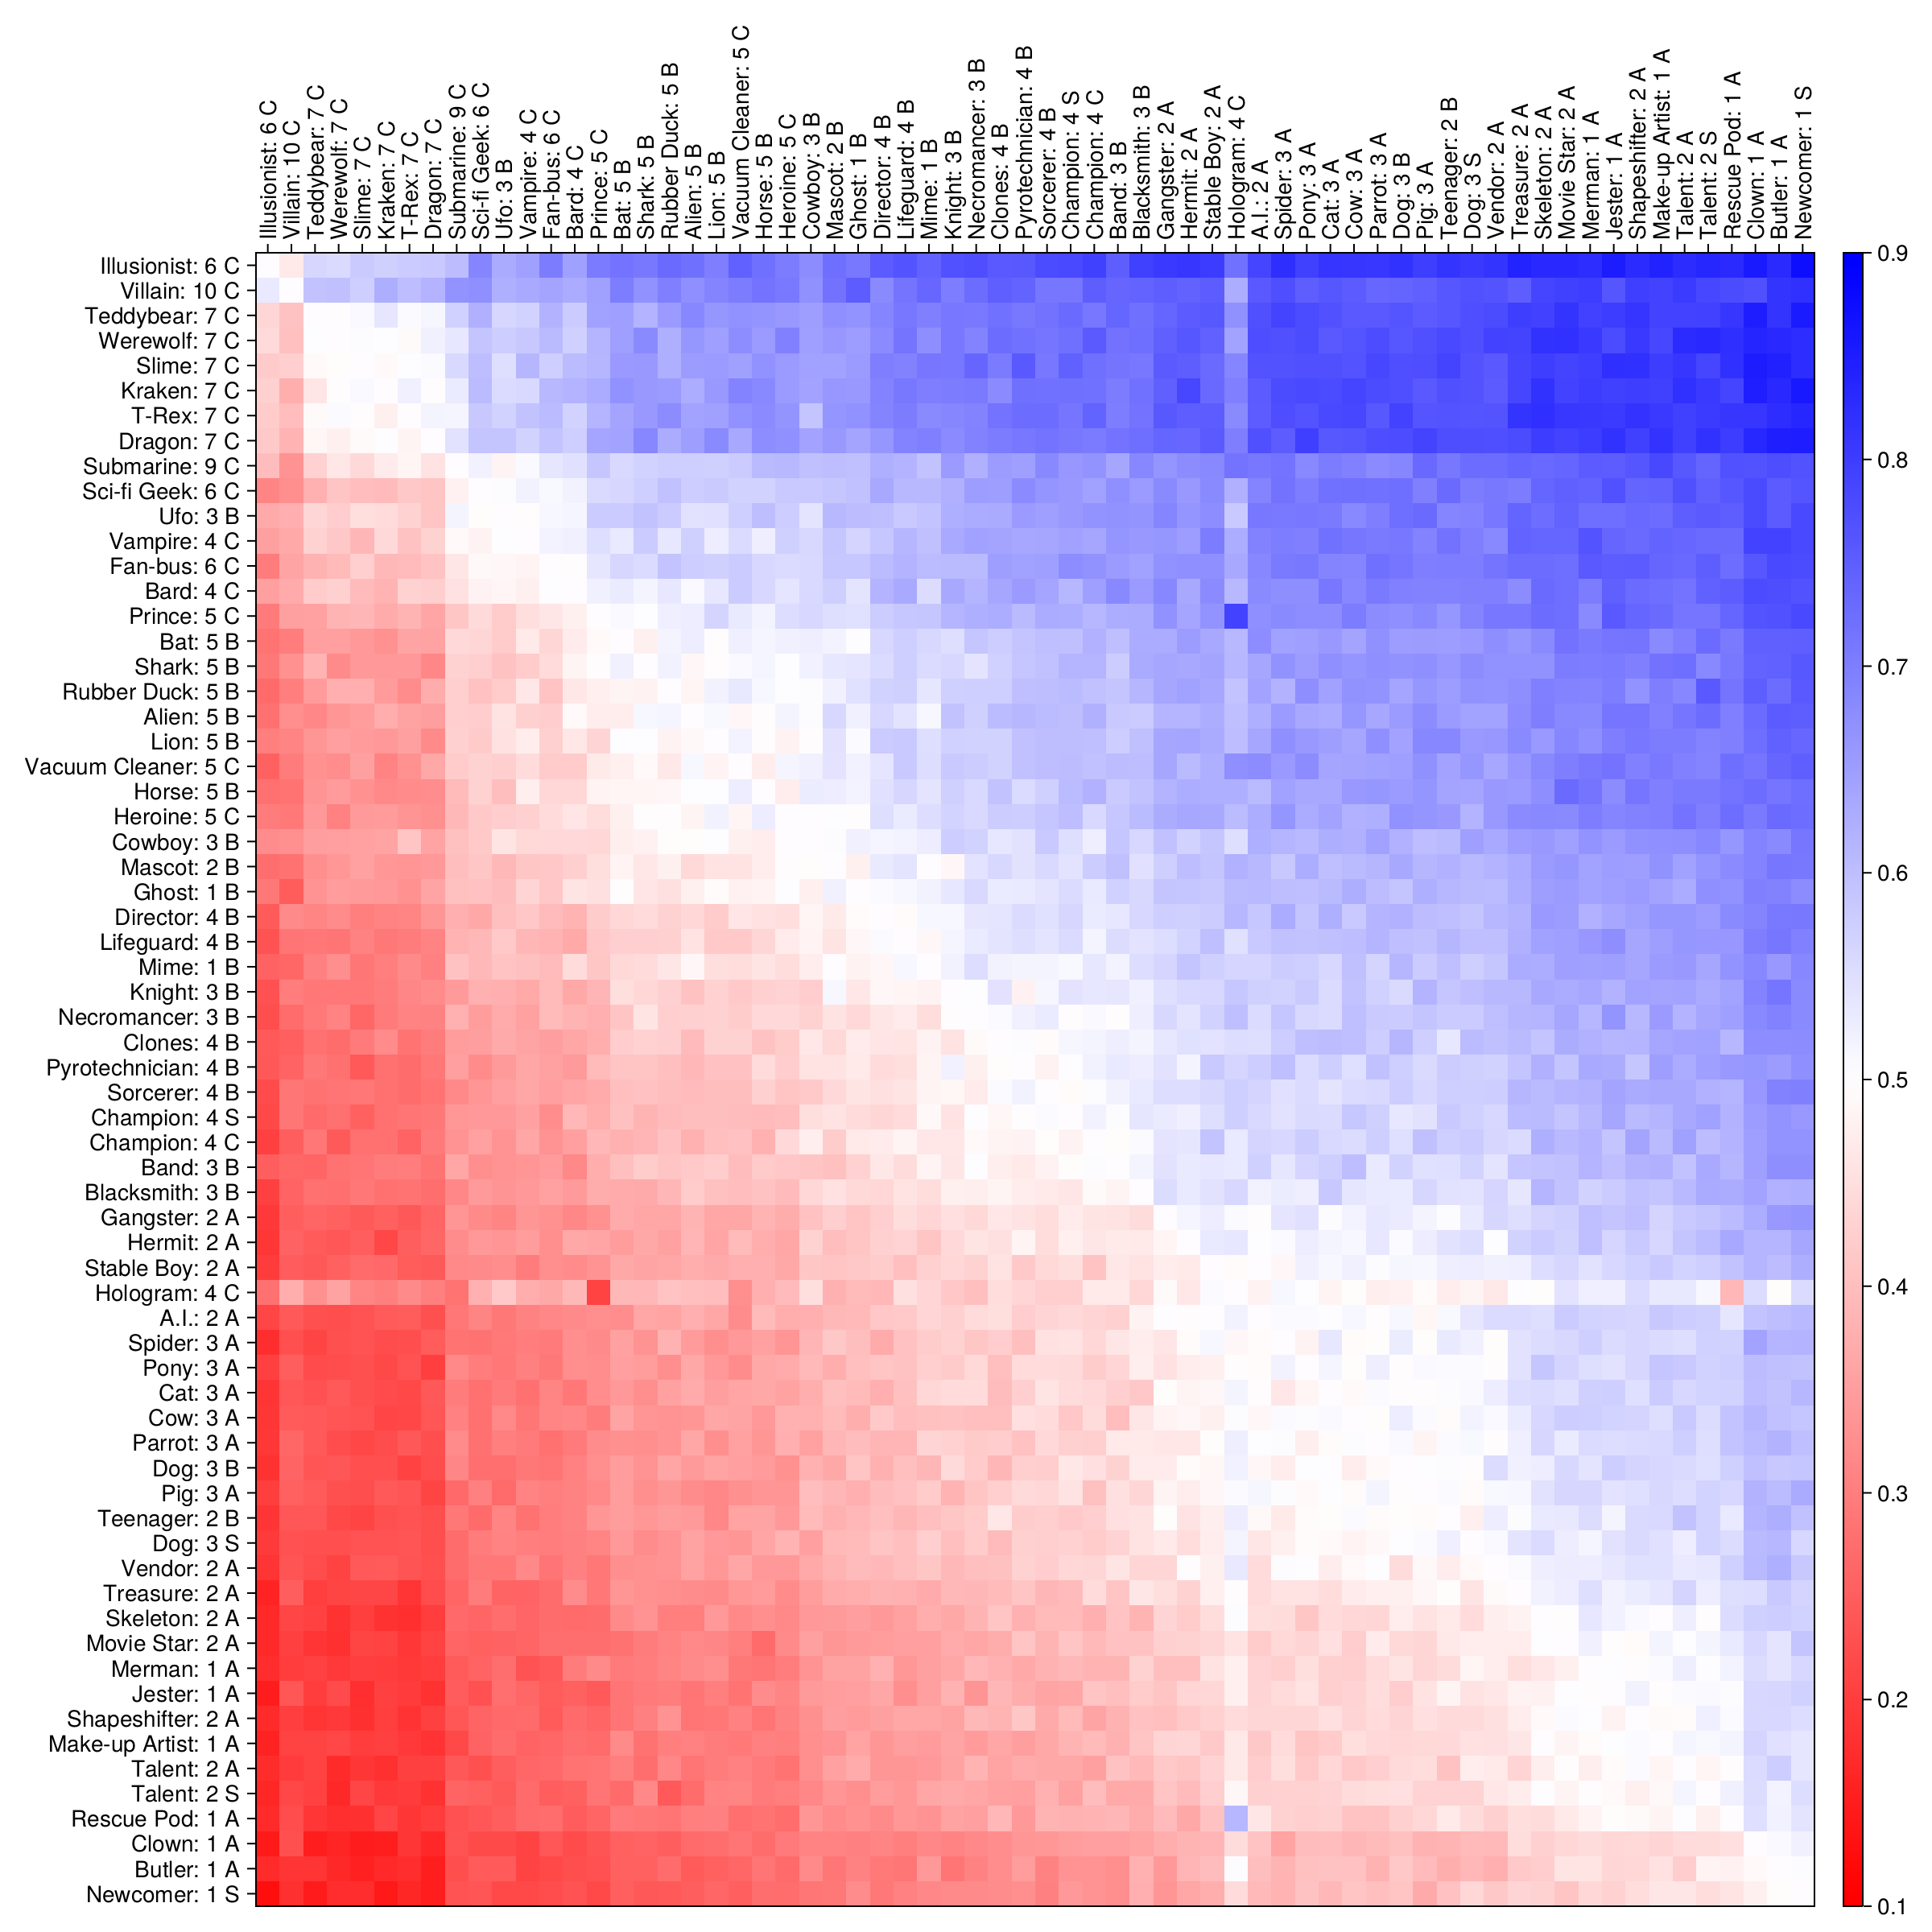

In [159]:
perm = sortperm(sum(vals, dims = 2)[:], rev = true);
fig = Figure(size = (1200,1200))
ticklabels = string.(allcards) .* " " .* origin.(allcards)
ax = Axis(fig[1,1], 
    xticks = (1:length(allcards), ticklabels[perm]), xticklabelrotation = pi/2, 
    yticks = (1:length(allcards), ticklabels[reverse(perm)]), xaxisposition=:top
)
c = ceil(norm(vals .- 0.5, Inf), digits = 1)
plt = heatmap!(ax, vals[reverse(perm), perm]', colorrange = (0.5 - c, 0.5 + c), colormap = Reverse(:bwr))
Colorbar(fig[1,2], plt, ticks = 0:0.1:1)
fig

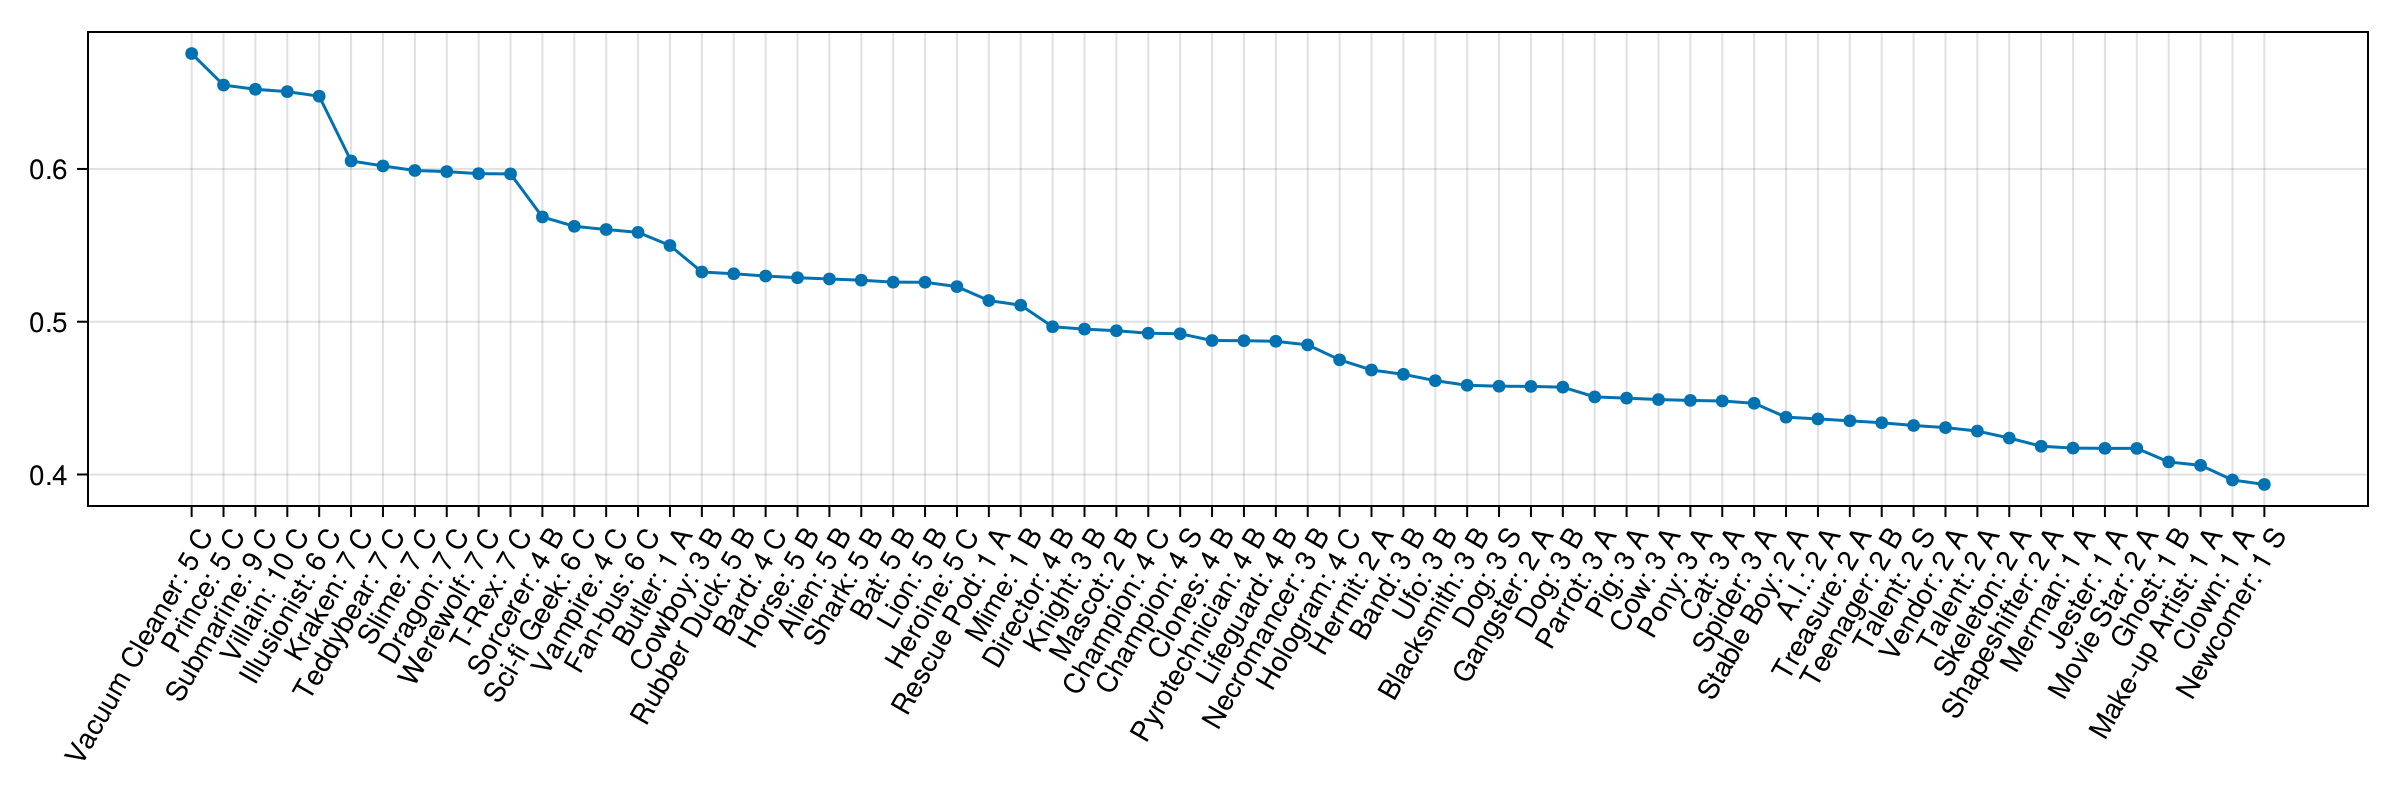

In [157]:
fig = Figure(size = (1200,400))
ax = Axis(fig[1,1], xticks = (1:length(allcards), ticklabels[perm]), xticklabelrotation = pi/3)
lines!(ax, mean(vals, dims = 2)[perm])
scatter!(ax, mean(vals, dims = 2)[perm])
fig

In [86]:
testcards = [Card("Test$i", i, "test", "T") for i in 1:10]
vals = fill(0.5, length(allcards), length(testcards))
prog = Progress(length(allcards) * length(testcards))
for i in 1:length(allcards), j in 1:length(testcards)
    nsamples = 50000
    vals[i,j] = sum(1:nsamples) do _
        cs = rand(allcards, 8)
        deck1 = [cs..., allcards[i]]
        deck2 = [cs..., testcards[j]]; 
        state = State(shuffle(deck1), shuffle(deck2))
        state.toplay = rand(Bool)
        simulate!(state) == 1
    end / nsamples
    next!(prog)
end

Progress: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| Time: 0:42:27


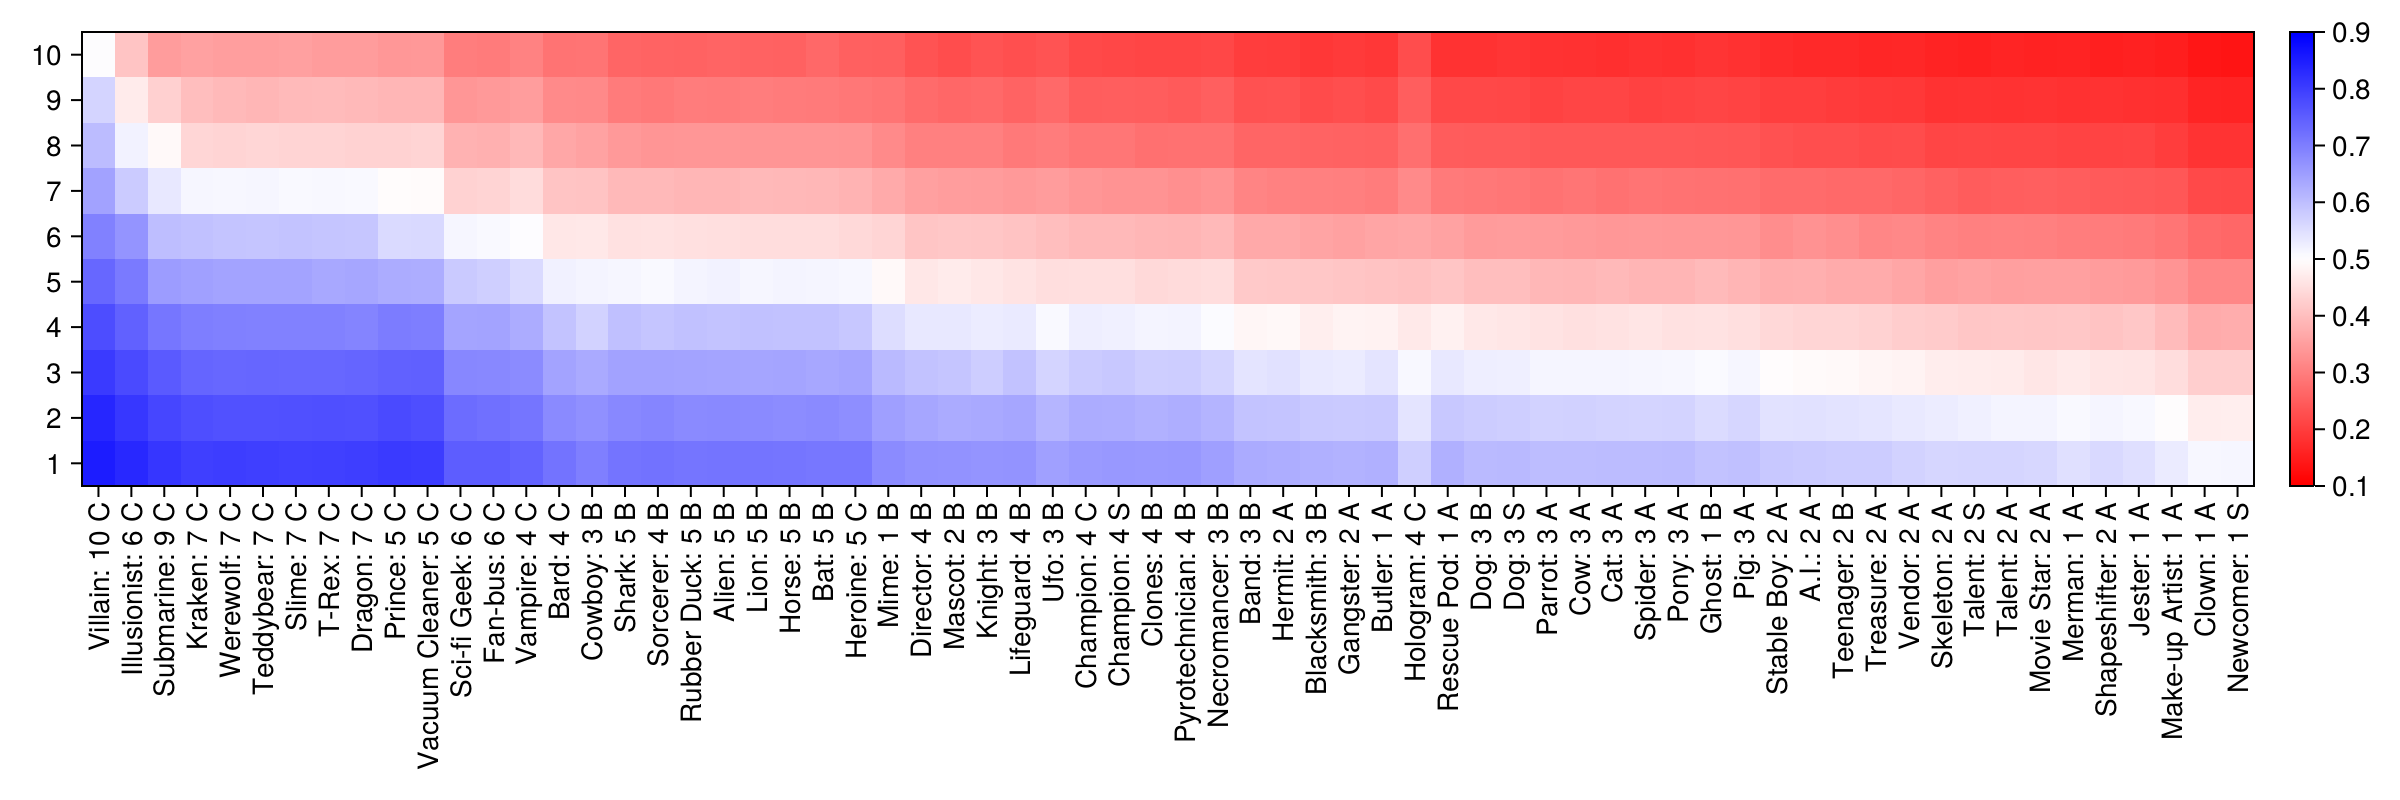

In [89]:
perm = sortperm(sum(vals, dims = 2)[:], rev = true);
fig = Figure(size = (1200,400))
ticklabels = string.(allcards) .* " " .* origin.(allcards)
ax = Axis(fig[1,1], 
    xticks = (1:length(allcards), ticklabels[perm]), xticklabelrotation = pi/2, 
    yticks = 1:length(testcards), xaxisposition=:bottom
)
c = ceil(norm(vals .- 0.5, Inf), digits = 1)
plt = heatmap!(ax, vals[perm, :], colorrange = (0.5 - c, 0.5 + c), colormap = Reverse(:bwr))
Colorbar(fig[1,2], plt, ticks = 0:0.1:1)
fig

In [91]:
save(numpath("out/cards.pdf"), fig)

CairoMakie.Screen{PDF}


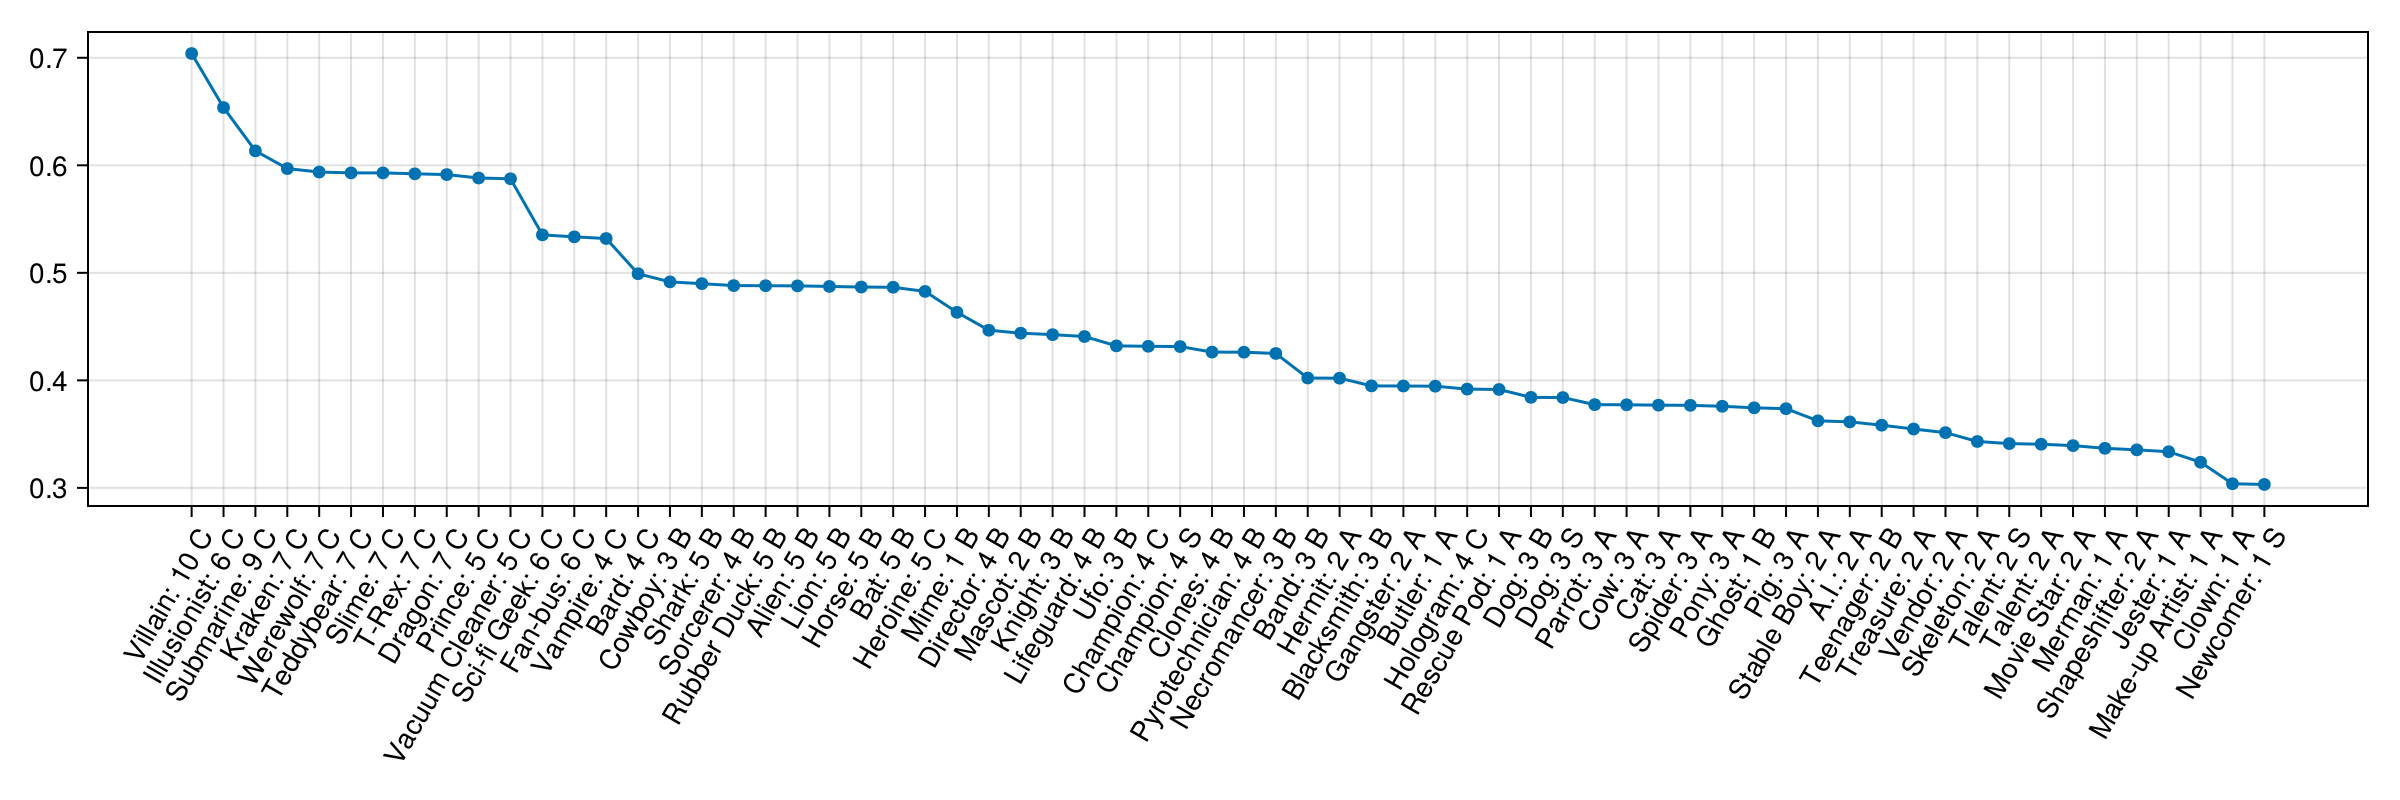

In [92]:
fig = Figure(size = (1200,400))
ax = Axis(fig[1,1], xticks = (1:length(allcards), ticklabels[perm]), xticklabelrotation = pi/3)
lines!(ax, mean(vals, dims = 2)[perm])
scatter!(ax, mean(vals, dims = 2)[perm])
fig

In [57]:
outcomes = map(1:10000) do i
    state = State(shuffle(deck1), shuffle(deck2))
    state.toplay = rand(Bool)
    simulate!(state)
end
mean(outcomes .== 1)

0.6986

In [230]:
1 - 1 / (factorial(12) / factorial(9) * factorial(6) / factorial(3))

0.9999936868686868

In [92]:
push!(fields[attacker], pop!(decks[attacker]))
if sum(power, fields[attacker], init = 0) >= (isempty(fields[defender]) ? 0 : power(fields[defender][end]))
    append!(benchs[defender], fields[defender]); empty!(fields[defender])
    attacker, defender = defender, attacker
end
println(attacker)
println.(decks)
println()
println.(fields)
println()
println.(benchs)

LoadError: ArgumentError: array must be non-empty